<a href="https://colab.research.google.com/github/jakinng/A-PINN/blob/main/multistage_nn_SNR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!python3 -m pip install pyDOE

###
### Multistage NN + SNR code (4/30/2024)

In [43]:
# from google.colab import drive
# drive.mount('/content/drive')

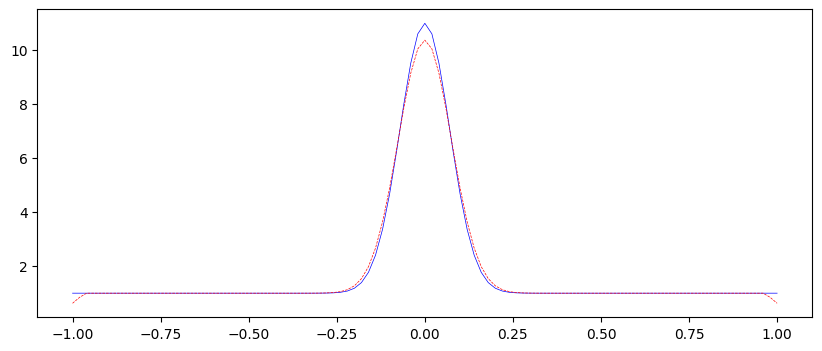

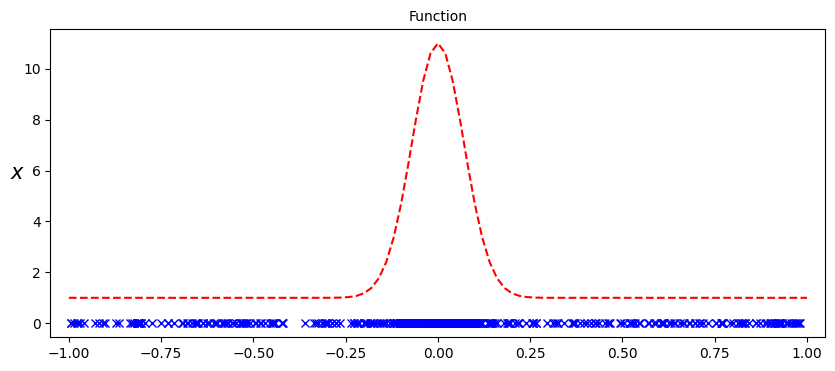

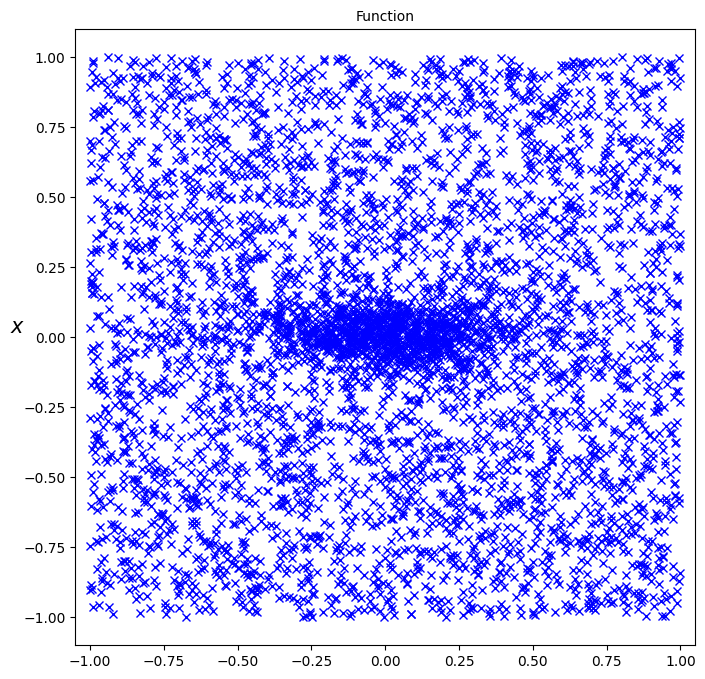

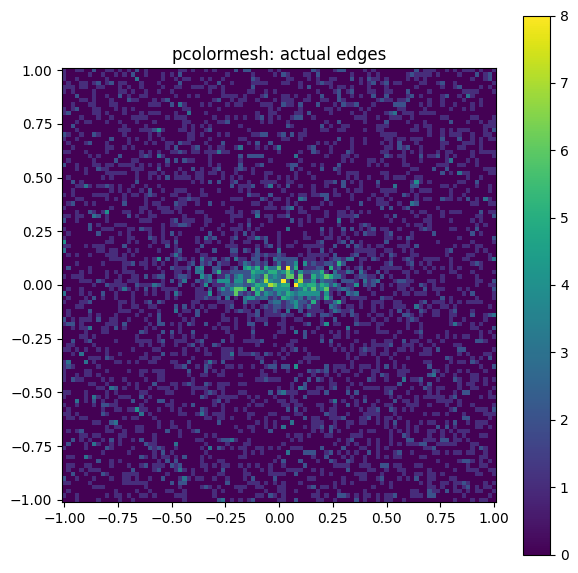

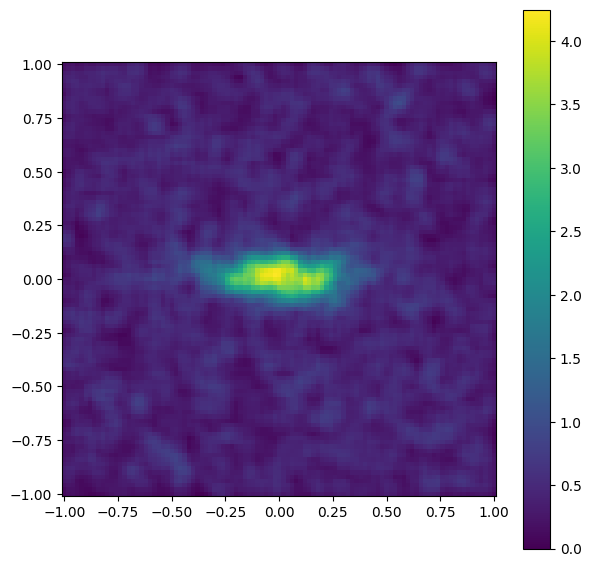

In [44]:
#@title Custom Sampling

import jax
import jax.numpy as jnp
import scipy
import jax.scipy as jsp
import matplotlib.pyplot as plt
import numpy as np

def gaussian1D_smooth(f, sig, wid):
    '''
    :param f: equally spaced 1D position matrix  (N, 1)
    :param sig: stan. devi of gaussian filter (1, ) or scalor
    :param wid: wid of the filter matrix (1, ) or scalor integer
    '''
    wid = jnp.int32(wid)
    xg = jnp.linspace(-sig, sig, wid)
    window = jsp.stats.norm.pdf(xg)
    win_n = window / jnp.sum(window)
    f_smooth = scipy.signal.convolve(f[:, 0], win_n, mode='same')[:, None]
    return f_smooth


# smooth the imaging using Gaussian filter
def gaussian2D_smooth(f, sig, wid):
    '''
    :param f: equally spaced 2D position matrix [N, N]
    :param sig: stan. devi of gaussian filter (2, )
    :param wid: wid of the filter matrix (2, ) integer
    '''
    wid = jnp.int32(wid)
    xg = jnp.linspace(-sig[0], sig[0], wid[0])
    yg = jnp.linspace(-sig[1], sig[1], wid[1])
    window = jsp.stats.norm.pdf(xg) * jsp.stats.norm.pdf(yg)[:, None]
    win_n = window / jnp.sum(window)
    f_smooth = scipy.signal.convolve2d(f, win_n, mode='same')
    return f_smooth


# sample the data based on a given probability distribution
def colloc1D_set(key, x, f, Ns):
    '''
    :param x: 1-D position array (N, 1)
    :param f: 1-D distribution array (N, 1)
    :param Ns: number of points to sample
    '''
    # remove last element in each direction
    xc = x[0:-1, :]
    fc = f[0:-1, :]
    dx = xc[1] - xc[0]
    seq = jnp.arange(fc.shape[0] + 1)
    # generate key for random variables
    keys = jax.random.split(key, num=2)

    # obtain the cumulative sum of the z value
    b = jnp.hstack([0., jnp.cumsum(fc)])
    # obtain the random variable
    c = jax.random.uniform(keys[0], [Ns]) * b[-1]
    # generate the index position of each collocation point following the distribution
    # (using the interpolate the index of grid where each random variable stands)
    posi_intp = jnp.interp(c, b, seq)
    # round the result to guarantee that the index position is integer
    posi = jnp.int32(jnp.floor(posi_intp))
    # obtain the real position of each collocation point
    px = xc[posi, :]
    # generate a random fraction for each collocation point
    posi_add = jax.random.uniform(keys[1], [c.shape[0], 1])
    # add the random fraction to the position of each collocation points
    x_col = px + posi_add * dx

    return x_col


# sample the data based on a given probability distribution
def colloc2D_set(key, X, Y, F, Ns):
    '''
    :param key: Key for random
    :param X: 2-D X position array (N, N)
    :param Y: 2-D Y position array (N, N)
    :param F: 2-D distribution array (N, N)
    :param Ns: number of points to sample
    '''

    # remove last element in each direction
    Xc = X[0:-1, 0:-1]
    Yc = Y[0:-1, 0:-1]
    Fc = F[0:-1, 0:-1]
    f = Fc.flatten()

    x = X[0, :]
    y = Y[:, 0]
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    seq = jnp.arange(f.shape[0] + 1)
    # generate key for random variables
    keys = jax.random.split(key, num=2)

    # obtain the cumulative sum of the z value
    b = jnp.hstack([0., jnp.cumsum(f)])
    # obtain the random variable
    c = jax.random.uniform(keys[0], [Ns]) * b[-1]

    # generate the index position of each collocation point following the distribution
    # (using the interpolate the index of grid where each random variable stands)
    posi_intp = jnp.interp(c, b, seq)
    # round the result to guarantee that the index position is integer
    posi_rd = jnp.floor(posi_intp)
    # obtain the 2D position of each collocation point in the position matrix
    idx_out = jnp.int32(jnp.floor(posi_rd / Fc.shape[1]))
    idx_in = jnp.int32(posi_rd % Fc.shape[1])
    # obtain the real position of each collocation point
    px = Xc[idx_out, idx_in]
    py = Yc[idx_out, idx_in]

    # generate a random fraction for each collocation point
    posi_add = jax.random.uniform(keys[1], [2, c.shape[0]])
    # add the random fraction to the position of each collocation points
    Px = px + posi_add[0] * dx
    Py = py + posi_add[1] * dy

    # group the x,y position of the collocation points into one [Nx2] matrix
    X_col = jnp.hstack((Px[:, None], Py[:, None]))

    return X_col

# sample the data based on a given probability distribution
def colloc2Dgrid_set(key, X, Y, F, Ns):
    '''
    :param key: Key for random
    :param X: 2-D X position array (N, N)
    :param Y: 2-D Y position array (N, N)
    :param F: 2-D distribution array (N, N)
    :param Ns: number of points to sample
    '''

    # remove last element in each direction
    Xc = X[0:, 0:]
    Yc = Y[0:, 0:]
    Fc = F[0:, 0:]
    f = Fc.flatten()

    x = X[0, :]
    y = Y[:, 0]
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    seq = jnp.arange(f.shape[0] + 1)
    # generate key for random variables
    keys = jax.random.split(key, num=2)

    # obtain the cumulative sum of the z value
    b = jnp.hstack([0., jnp.cumsum(f)])
    # obtain the random variable
    c = jax.random.uniform(keys[0], [Ns]) * b[-1]

    # generate the index position of each collocation point following the distribution
    # (using the interpolate the index of grid where each random variable stands)
    posi_intp = jnp.interp(c, b, seq)
    # round the result to guarantee that the index position is integer
    posi_rd = jnp.floor(posi_intp)
    # obtain the 2D position of each collocation point in the position matrix
    idx_out = jnp.int32(jnp.floor(posi_rd / Fc.shape[1]))
    idx_in = jnp.int32(posi_rd % Fc.shape[1])
    idx_1d = idx_out * Fc.shape[1] + idx_in
    # # obtain the real position of each collocation point
    # px = Xc[idx_out, idx_in]
    # py = Yc[idx_out, idx_in]
    # # group the x,y position of the collocation points into one [Nx2] matrix
    # X_col = jnp.hstack((px[:, None], py[:, None]))
    # X_col2 = Xc.flatten()[idx_1d]
    return idx_1d

if __name__ == "__main__":
    # example for the 1D collocation set
    x = jnp.linspace(-1, 1, 101)[:, None]
    f = 10 * jnp.exp(-100 * x**2) + 1
    f_s = gaussian1D_smooth(f, 1, 5)  # f must be column
    Ns = 500

    fig = plt.figure(figsize=[10, 4], dpi=100)
    ax = plt.subplot(111)
    ax.plot(x, f, 'b-', linewidth=0.5)
    ax.plot(x, f_s, 'r--', linewidth=0.5)
    plt.show()

    seed = np.random.choice(1000, 1)
    key = jax.random.PRNGKey(seed[0])
    x_col = colloc1D_set(key, x, f, Ns)

    fig = plt.figure(figsize=[10, 4], dpi=100)
    ax = plt.subplot(111)
    ax.plot(x_col, jnp.zeros(x_col.shape), 'bx', linewidth=0.5)
    ax.plot(x, f, 'r--')
    ax.set_ylabel('$x$', fontsize=15, rotation=0)
    ax.set_title('Function', fontsize=10)
    ax.set_xlim([-1.05, 1.05])
    plt.show()

    #%% example for the 2D collocation set
    x = jnp.linspace(-1, 1, 101)
    y = jnp.linspace(-1, 1, 101)
    X, Y = jnp.meshgrid(x, y)
    F = 10 * jnp.exp(-10 * (X ** 2 + 10*Y ** 2)) + 1
    Ns = 5000

    seed = np.random.choice(1000, 1)
    seed = [509]
    key = jax.random.PRNGKey(seed[0])
    X_col = colloc2D_set(key, X, Y, F, Ns)

    fig2 = plt.figure(figsize=[8, 8], dpi=100)
    ax = plt.subplot(111)
    ax.plot(X_col[:, 0], X_col[:, 1], 'bx', linewidth=0.5)
    ax.set_ylabel('$x$', fontsize=15, rotation=0)
    ax.set_title('Function', fontsize=10)
    ax.set_xlim([-1.05, 1.05])
    plt.show()

    #%% obtain the histogram from the sampling data

    H = jnp.histogram2d(X_col[:,0], X_col[:, 1], bins=[x.shape[0], y.shape[0]])[0]
    H = H.T  # Histogram does not follow Cartesian convention

    fig3 = plt.figure(figsize=(7, 7))
    ax = fig3.add_subplot(111, title='pcolormesh: actual edges', aspect='equal')
    im = ax.pcolormesh(X, Y, H)
    fig3.colorbar(im, ax=ax)
    plt.show()

    #%% smooth the histogram using Gaussion filter

    H_sm = gaussian2D_smooth(H, [1, 1], [5, 5])
    fig4 = plt.figure(figsize=(7, 7))
    ax = fig4.add_subplot(111, aspect='equal')
    im2 = ax.pcolormesh(X, Y, H_sm)
    fig4.colorbar(im2, ax=ax)
    plt.show()


    #%%
    # import matplotlib.pyplot as plt

    # fig4 = plt.figure(figsize=(7, 7))
    # ax = fig4.add_subplot(111, aspect='auto')
    # im = ax.pcolormesh(R[0], Th[0], F[0])
    # fig4.colorbar(im, ax=ax)
    # plt.show()

    # X_col = data['x_col']
    # fig2 = plt.figure(figsize=[8, 8], dpi=100)
    # ax = plt.subplot(111)
    # ax.plot(X_col[:, 0], X_col[:, 1], 'bx', linewidth=0.5)
    # ax.set_ylabel('$x$', fontsize=15, rotation=0)
    # ax.set_title('Function', fontsize=10)
    # plt.show()

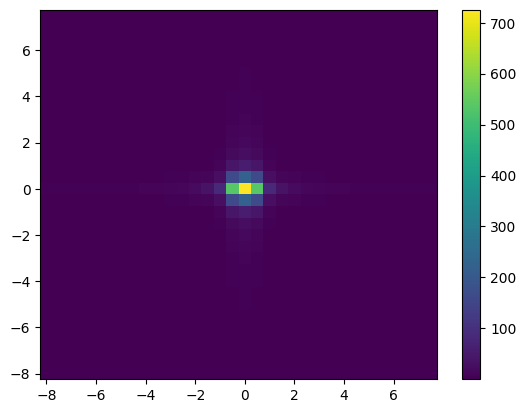

nmode=Array(1310, dtype=int64)
layers=[1310, 10, 1]
net_scl=Array(11.17875389, dtype=float64)
1.5245658372802677e-09, 0.07255148974132633


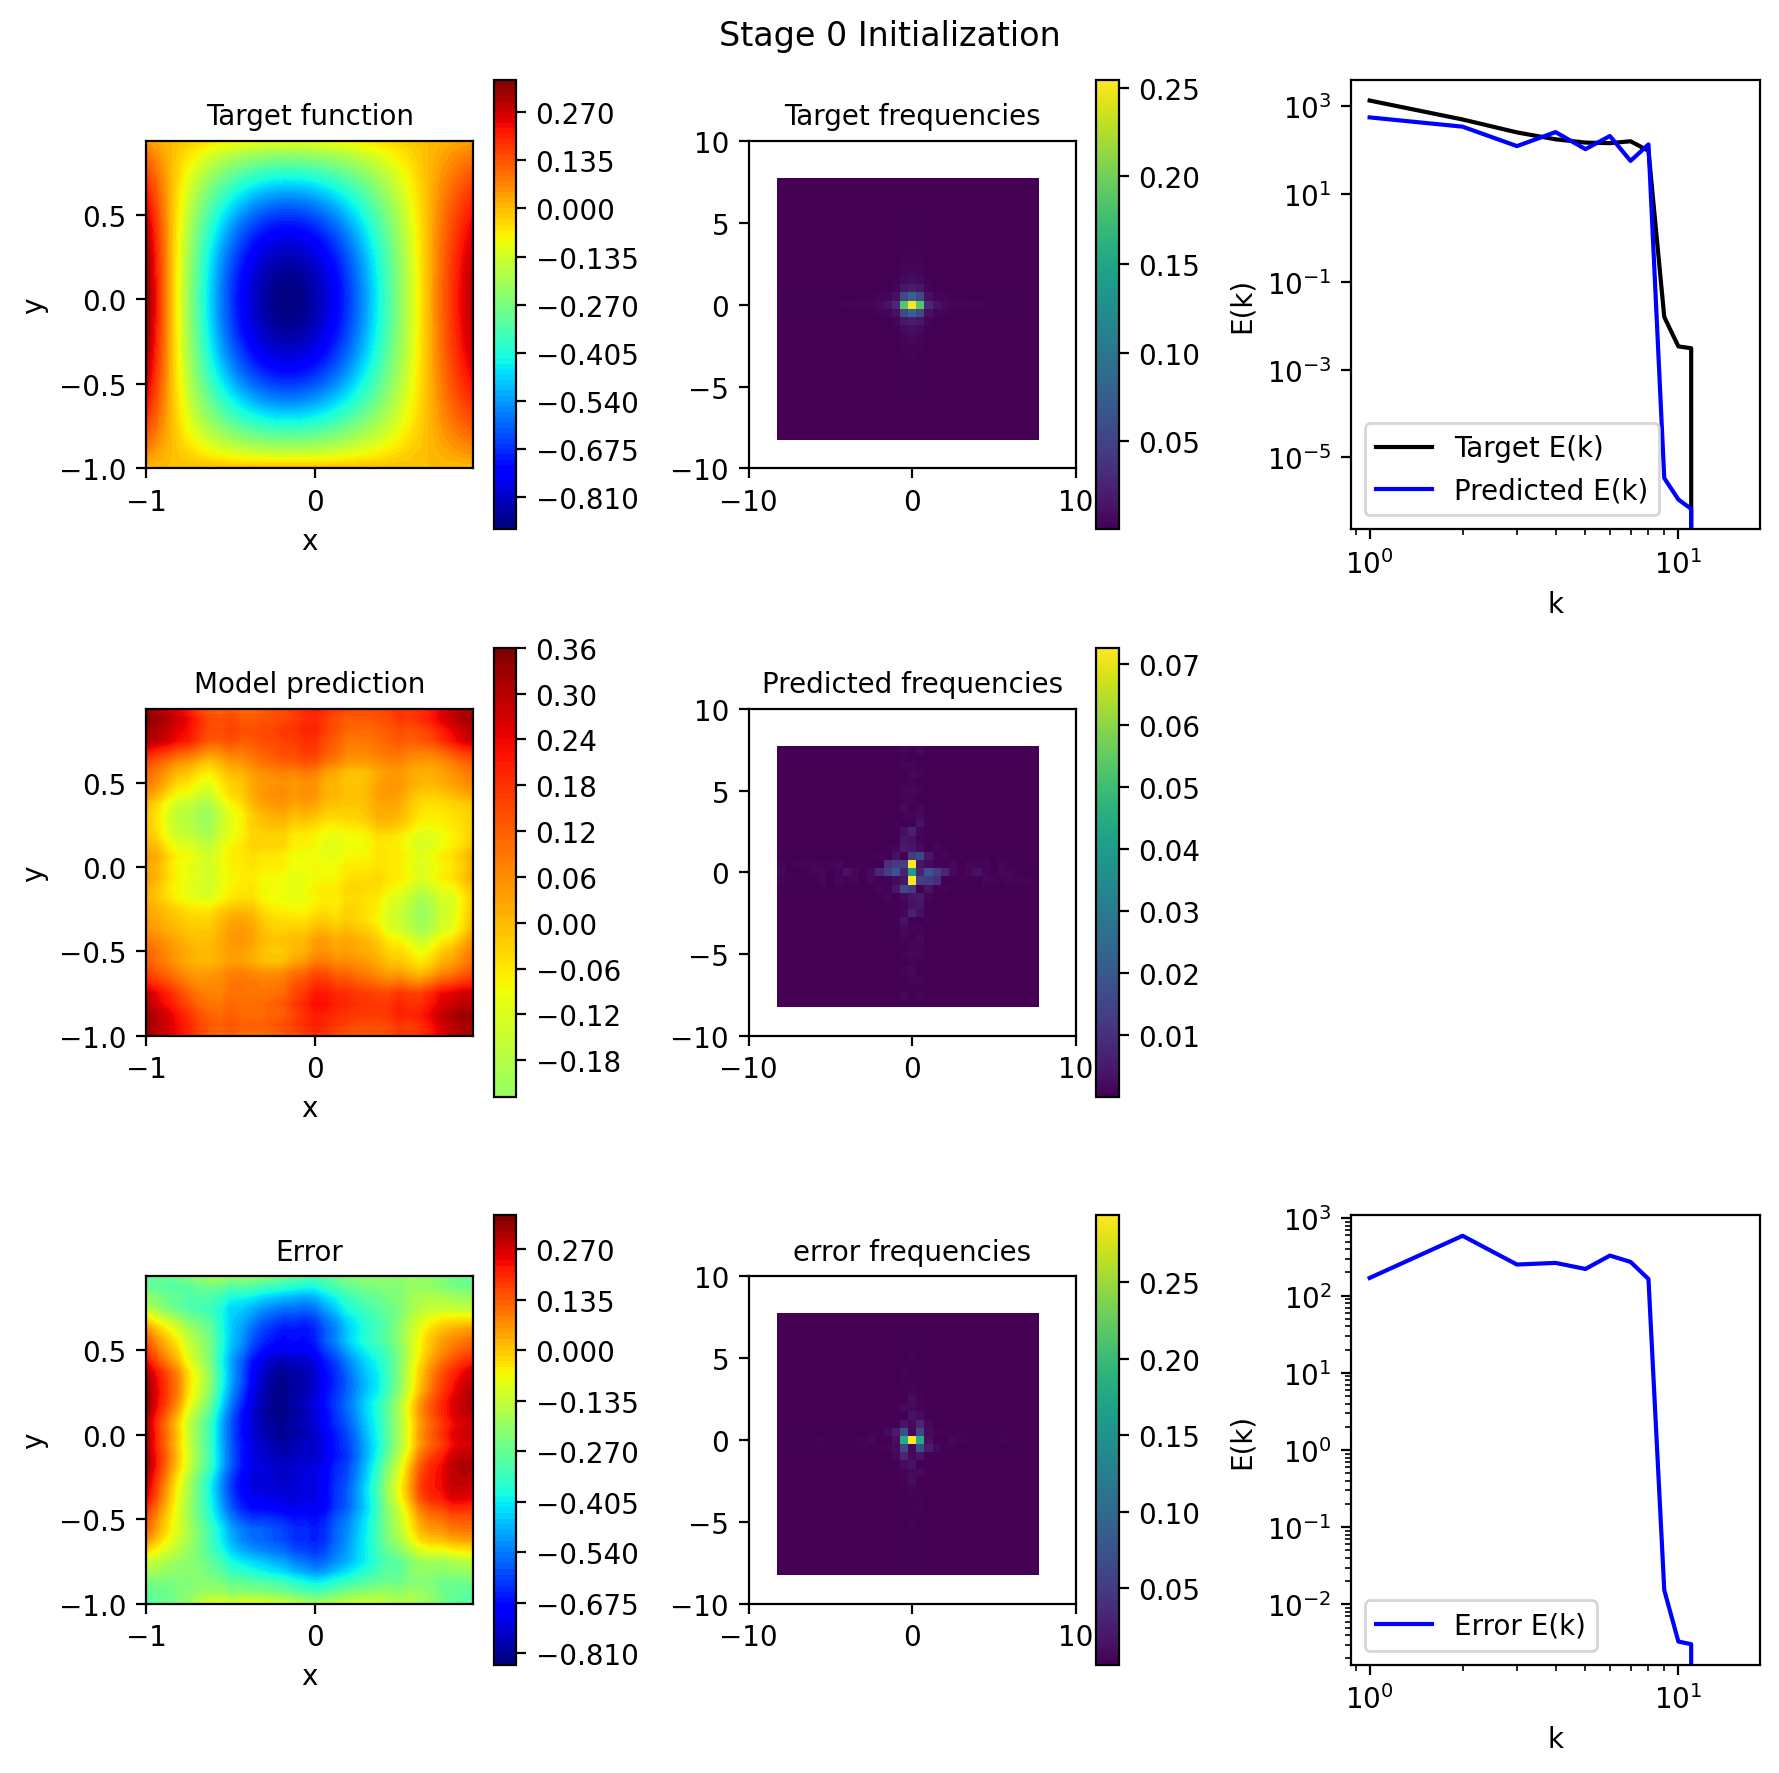

Step: 0 | Loss: 1.7341e+00


the file name should be /content/drive/MyDrive/Stanford/2024_04_17/reg2d_test3_p10_iters2000_stage0_params_iter0.pkl


Step: 100 | Loss: 3.4971e-02
Step: 200 | Loss: 4.8645e-02
Step: 300 | Loss: 6.5388e-02
Step: 400 | Loss: 6.9386e-02
Step: 500 | Loss: 5.6706e-02


the file name should be /content/drive/MyDrive/Stanford/2024_04_17/reg2d_test3_p10_iters2000_stage0_params_iter500.pkl


Step: 600 | Loss: 3.8003e-02
Step: 700 | Loss: 4.5165e-02
Step: 800 | Loss: 4.2220e-02
Step: 900 | Loss: 2.8764e-02
Step: 1000 | Loss: 3.8198e-02


the file name should be /content/drive/MyDrive/Stanford/2024_04_17/reg2d_test3_p10_iters2000_stage0_params_iter1000.pkl


Step: 1100 | Loss: 3.9731e-02
Step: 1200 | Loss: 2.8650e-02
Step: 1300 | Loss: 3.6007e-02
Step: 1400 | Loss: 3.7328e-02
Step: 1500 | Loss: 2.8096e-02


the file name should be /content/drive/MyDrive/Stanford/2024_04_17/reg2d_test3_p10_iters2000_stage0_params_iter1500.pkl


Step: 1600 | Loss: 3.4424e-02
Step: 1700 | Loss: 3.3959e-02
Step: 1800 | Loss: 2.6487e-02
Step: 1900 | Loss: 3.4382e-02
Step: final | Loss: 3.6291e-02


1.0781856053611089e-06, 0.2556266999935833


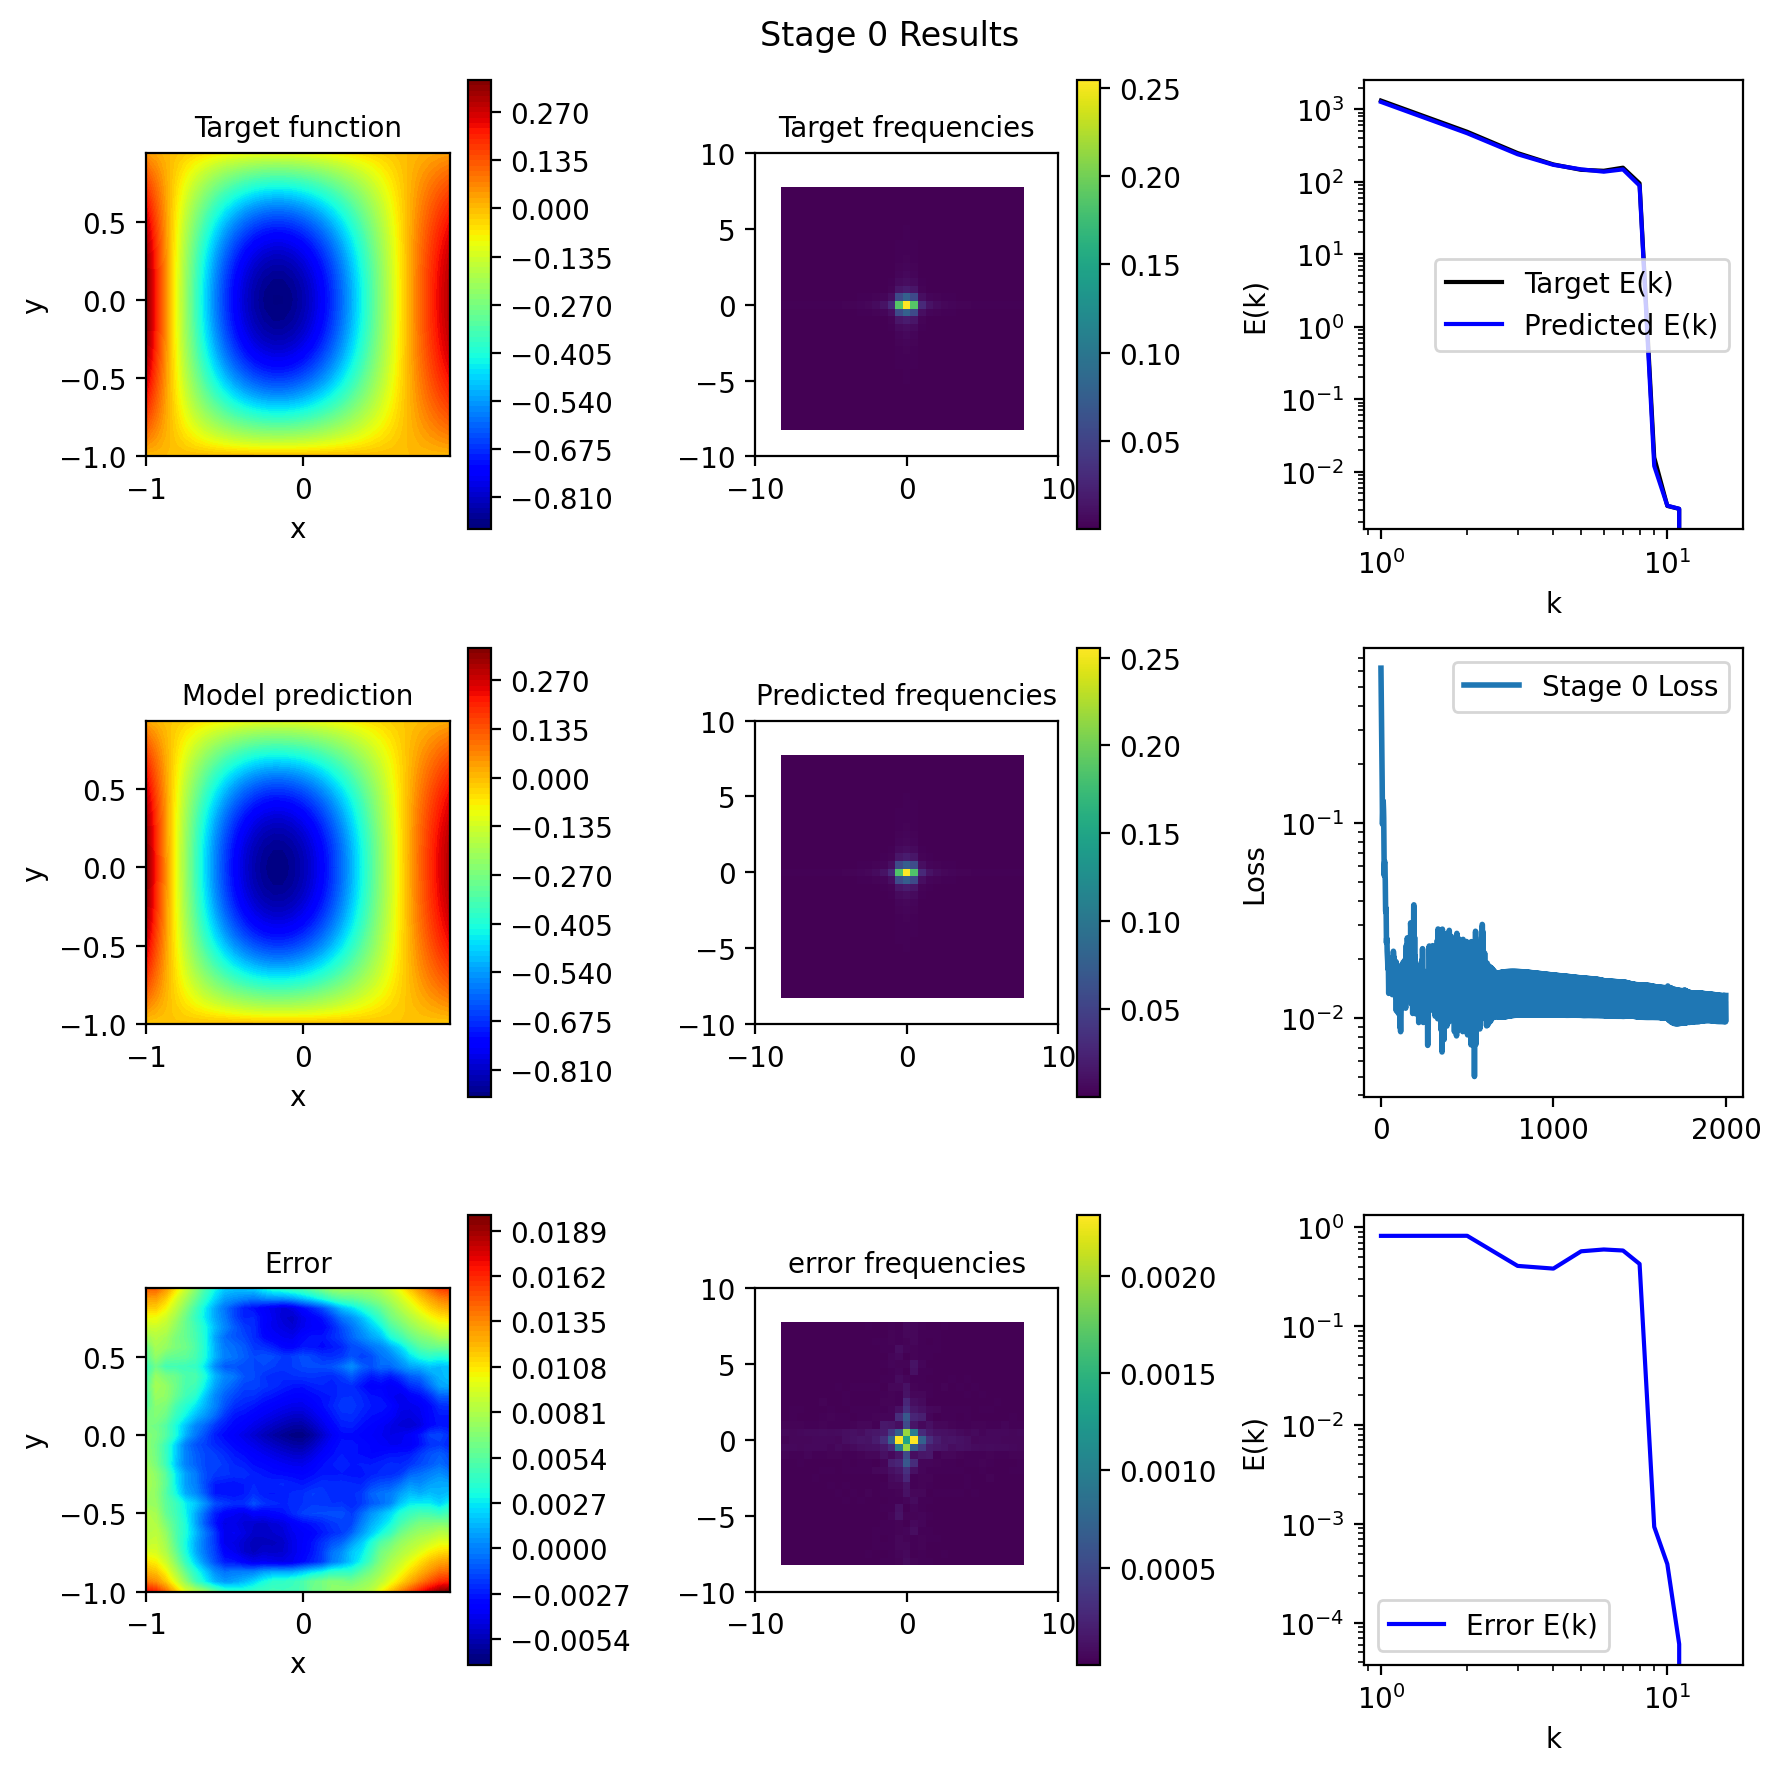

1.0781856053611089e-06, 0.2556266999935833


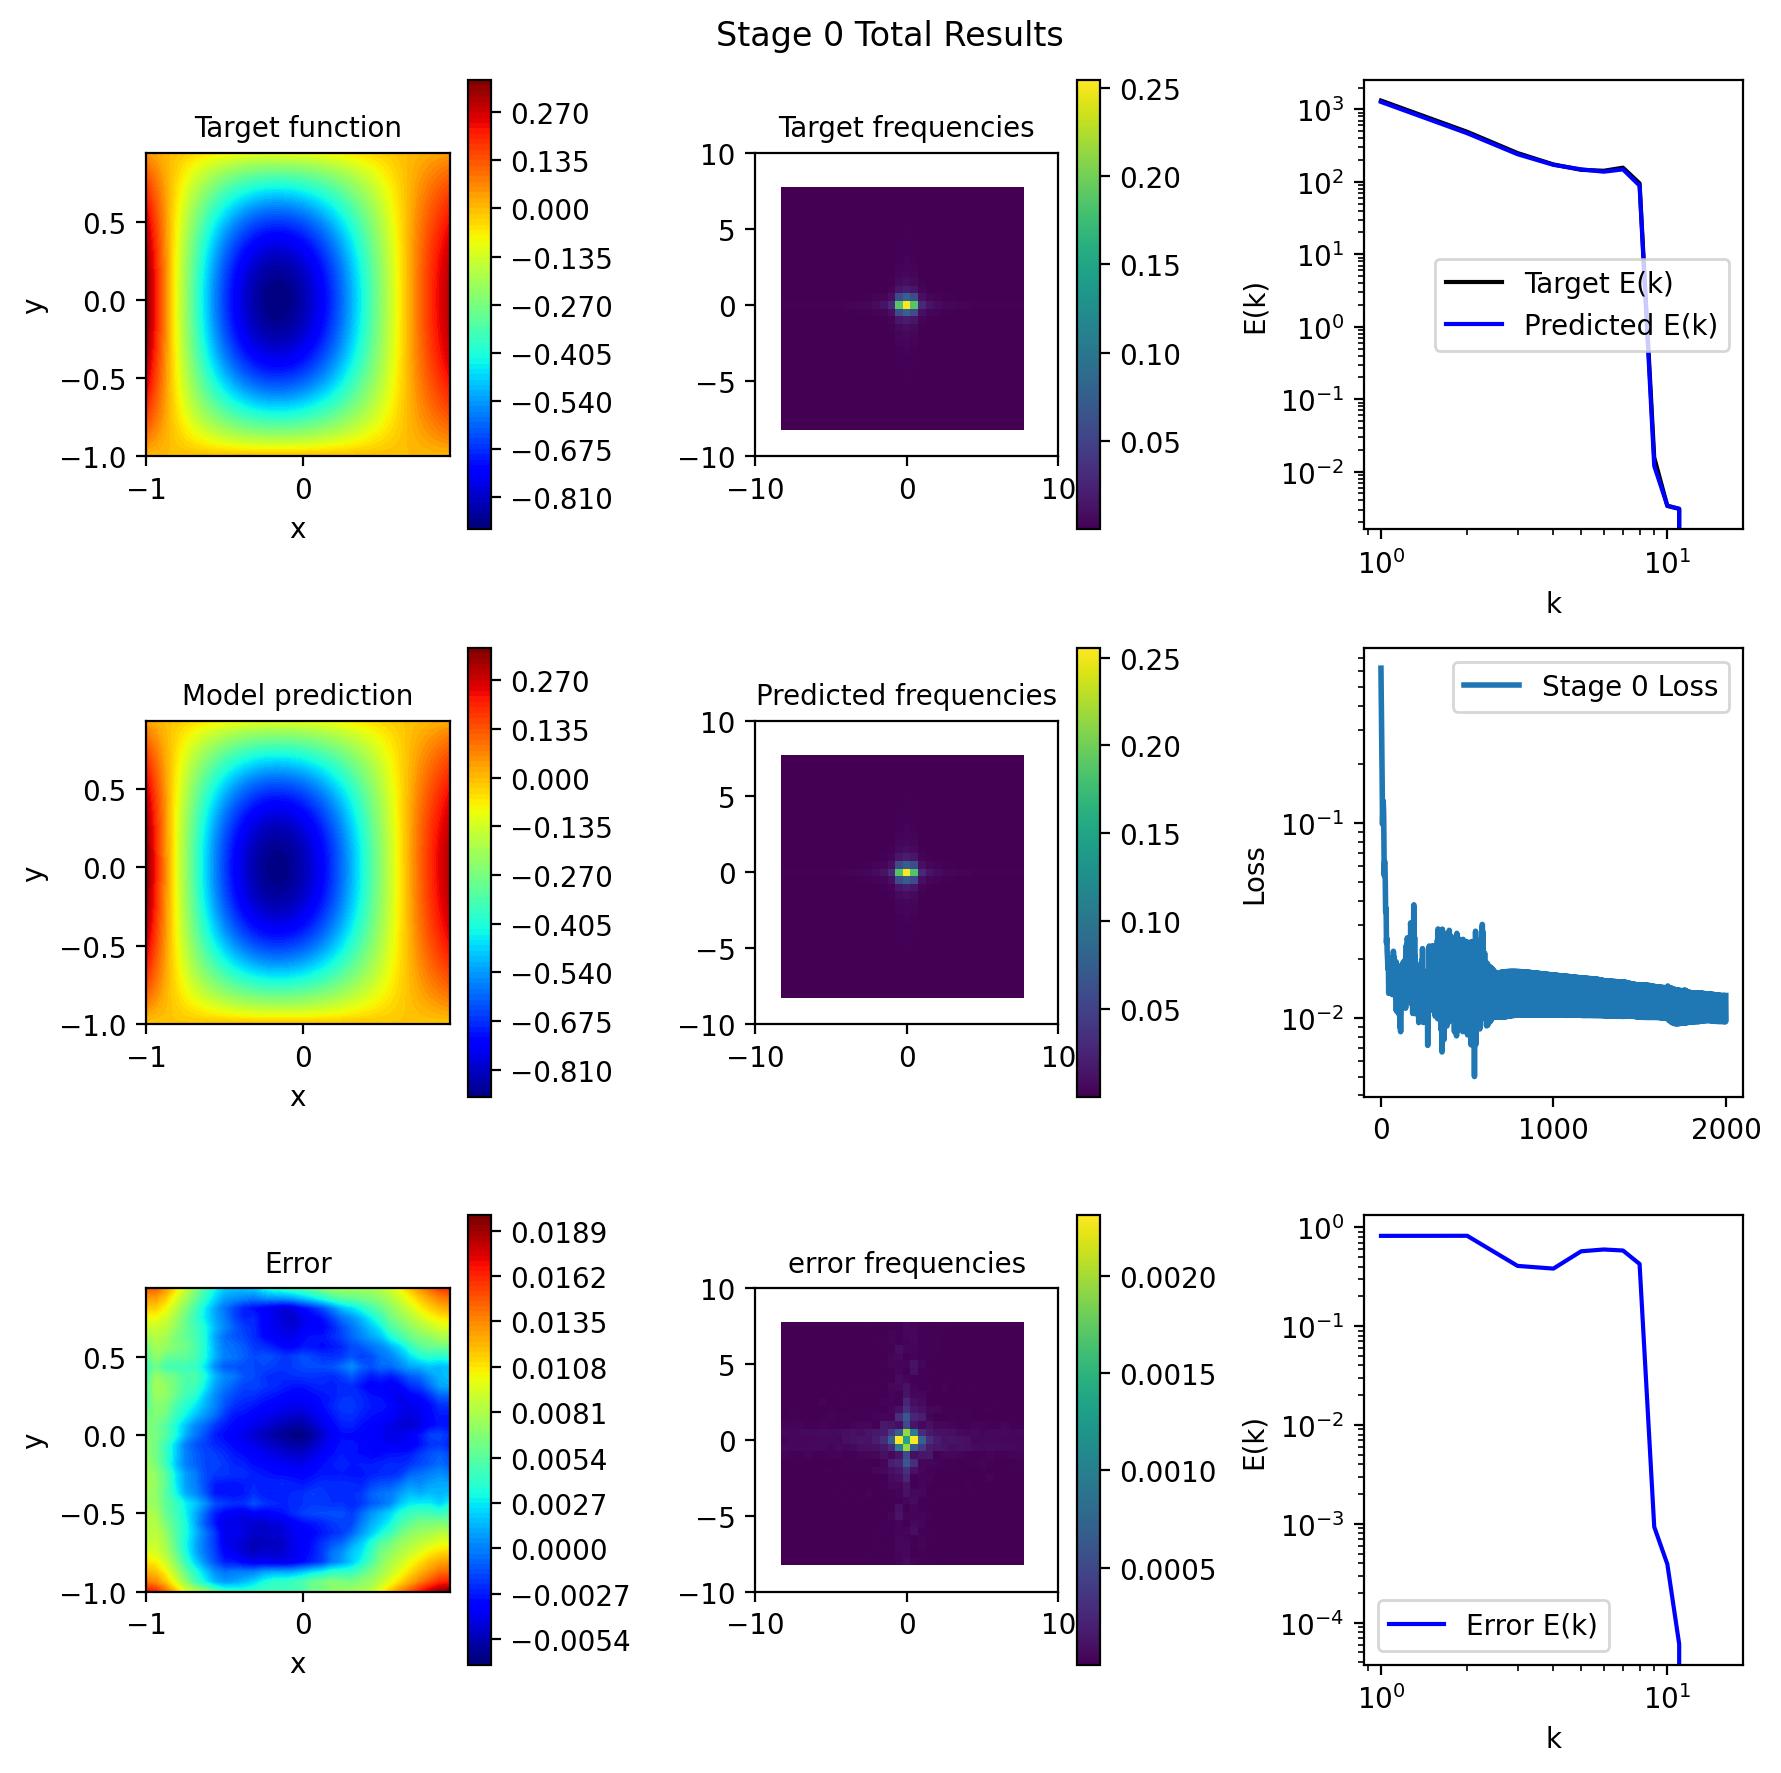

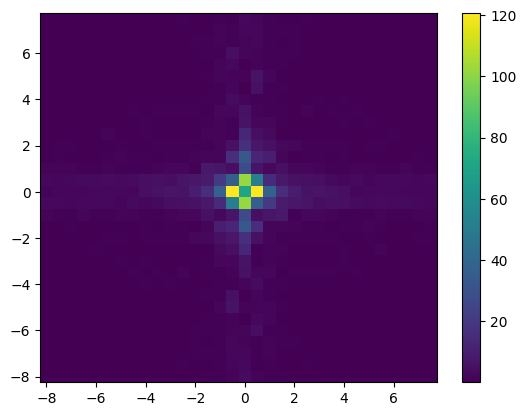

nmode=Array(2040, dtype=int64)
layers=[2040, 10, 1]
net_scl=Array(5.64639968, dtype=float64)
7.0850098523536466e-09, 0.0028572578999593117


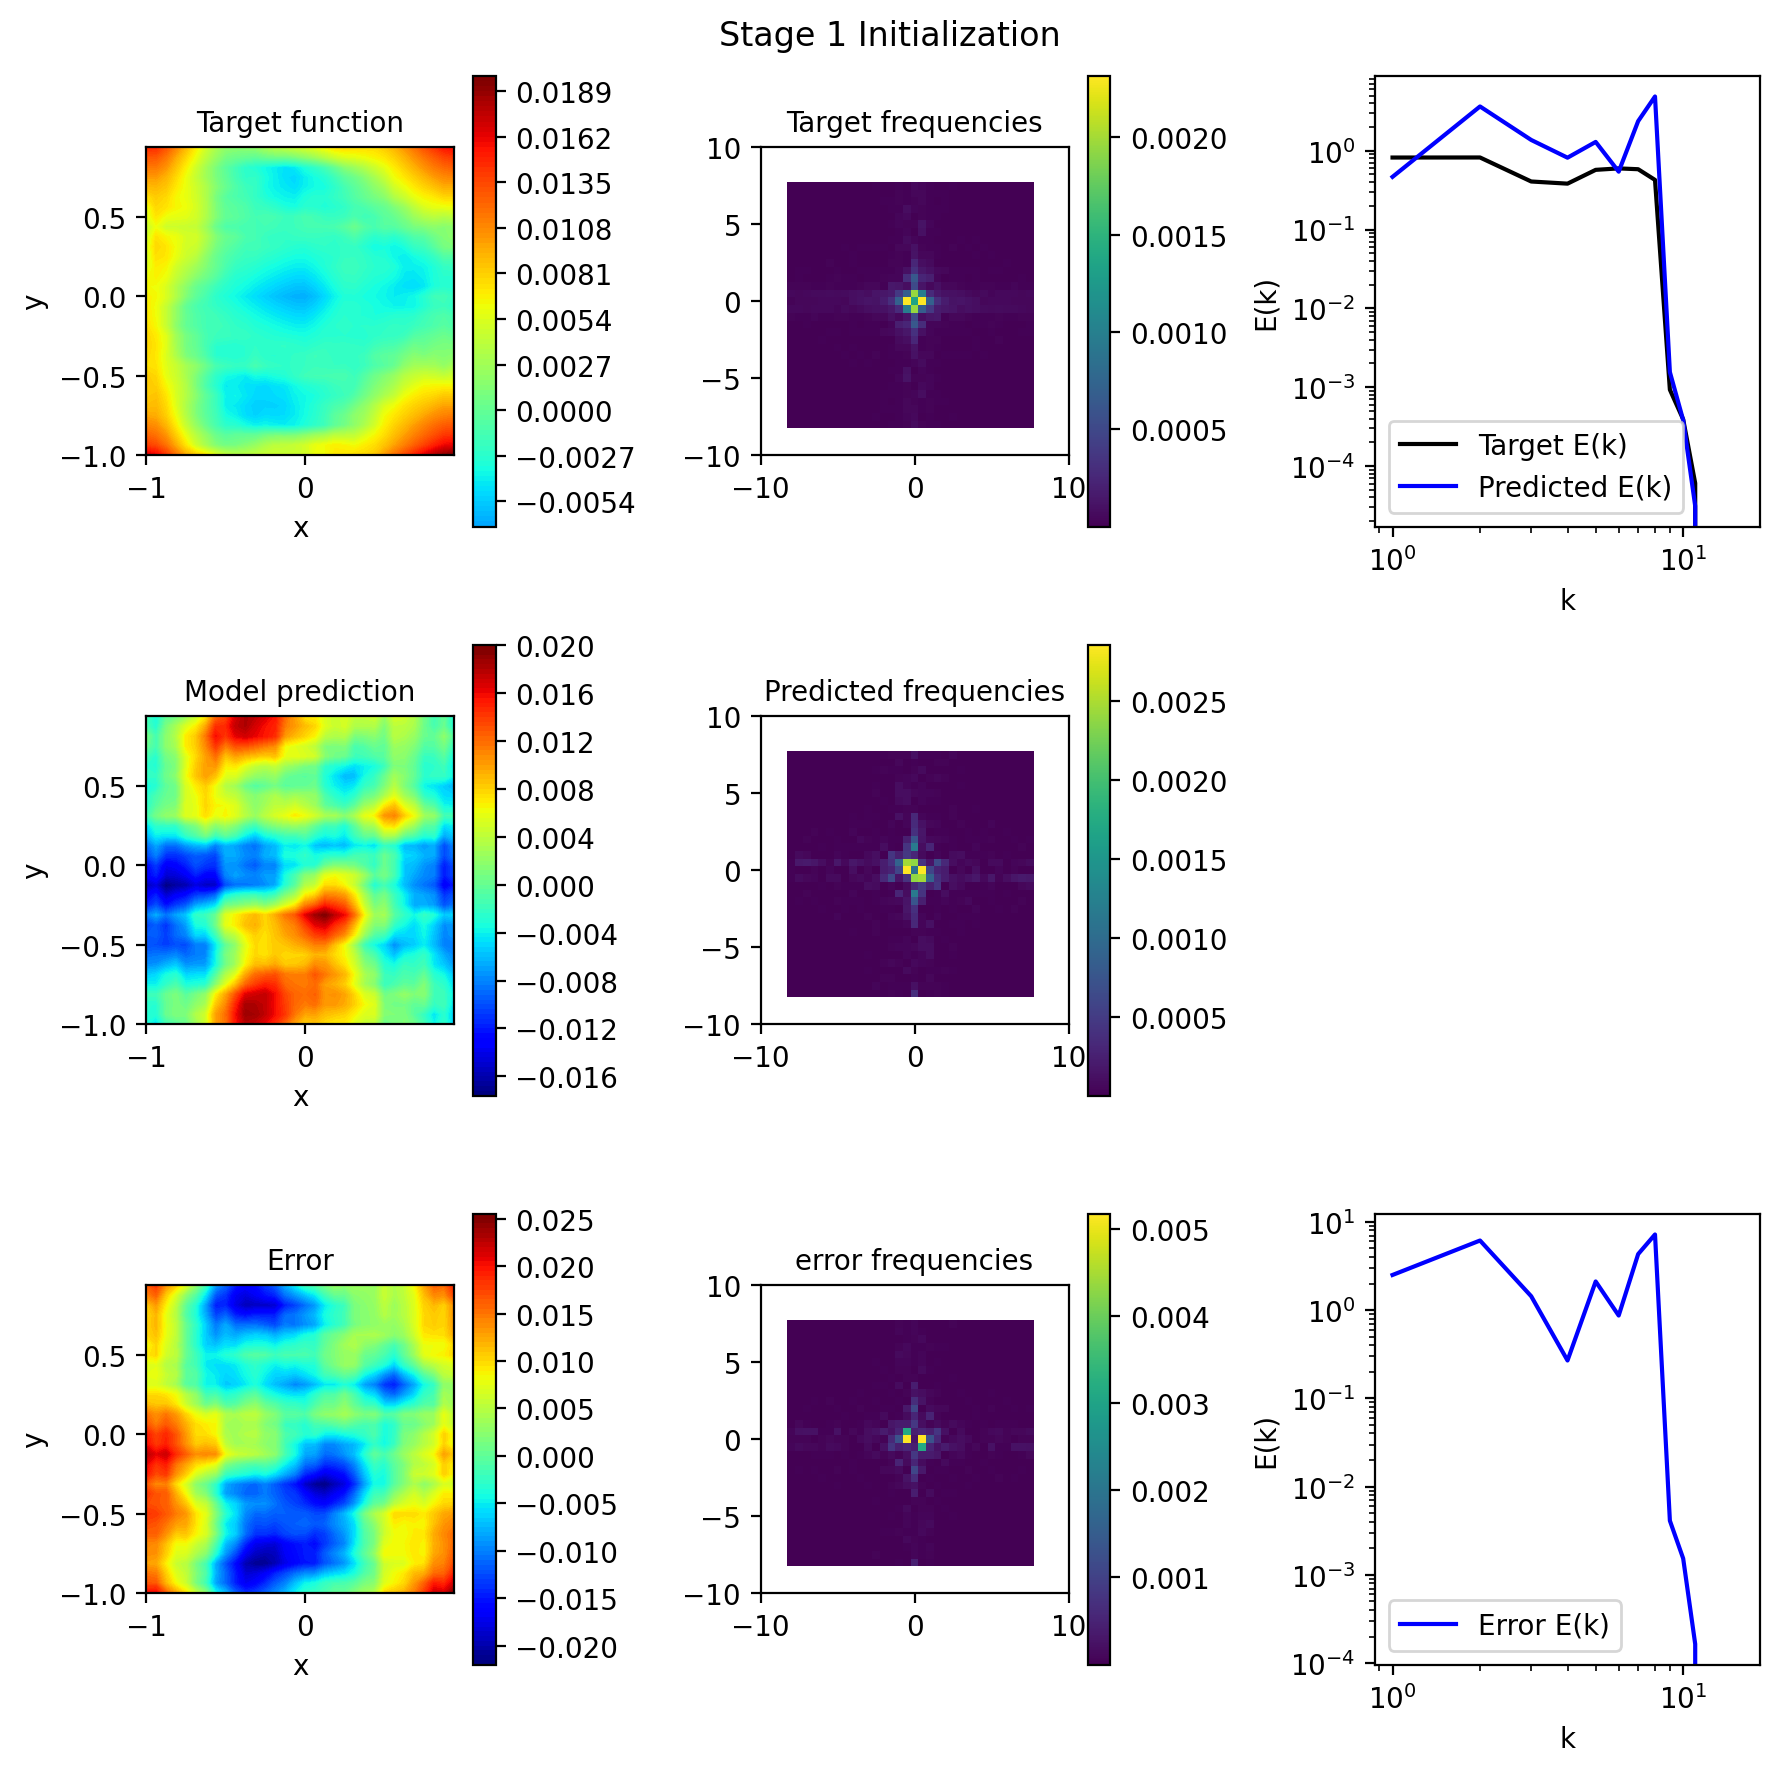

Step: 0 | Loss: 7.7982e-01


the file name should be /content/drive/MyDrive/Stanford/2024_04_17/reg2d_test3_p10_iters2000_stage1_params_iter0.pkl


Step: 100 | Loss: 2.9015e-02
Step: 200 | Loss: 2.9445e-02
Step: 300 | Loss: 2.1286e-02
Step: 400 | Loss: 2.9810e-02
Step: 500 | Loss: 2.5007e-02


the file name should be /content/drive/MyDrive/Stanford/2024_04_17/reg2d_test3_p10_iters2000_stage1_params_iter500.pkl


Step: 600 | Loss: 2.4826e-02
Step: 700 | Loss: 2.3427e-02
Step: 800 | Loss: 3.4793e-02
Step: 900 | Loss: 2.4176e-02
Step: 1000 | Loss: 1.5415e-02


the file name should be /content/drive/MyDrive/Stanford/2024_04_17/reg2d_test3_p10_iters2000_stage1_params_iter1000.pkl


Step: 1100 | Loss: 2.5323e-02
Step: 1200 | Loss: 1.7074e-02
Step: 1300 | Loss: 1.9052e-02
Step: 1400 | Loss: 1.3749e-02
Step: 1500 | Loss: 2.1043e-02


the file name should be /content/drive/MyDrive/Stanford/2024_04_17/reg2d_test3_p10_iters2000_stage1_params_iter1500.pkl


Step: 1600 | Loss: 1.9469e-02
Step: 1700 | Loss: 1.4640e-02
Step: 1800 | Loss: 1.4567e-02
Step: 1900 | Loss: 2.2100e-02
Step: final | Loss: 1.8098e-02


2.0605778966159358e-08, 0.0022865974971782916


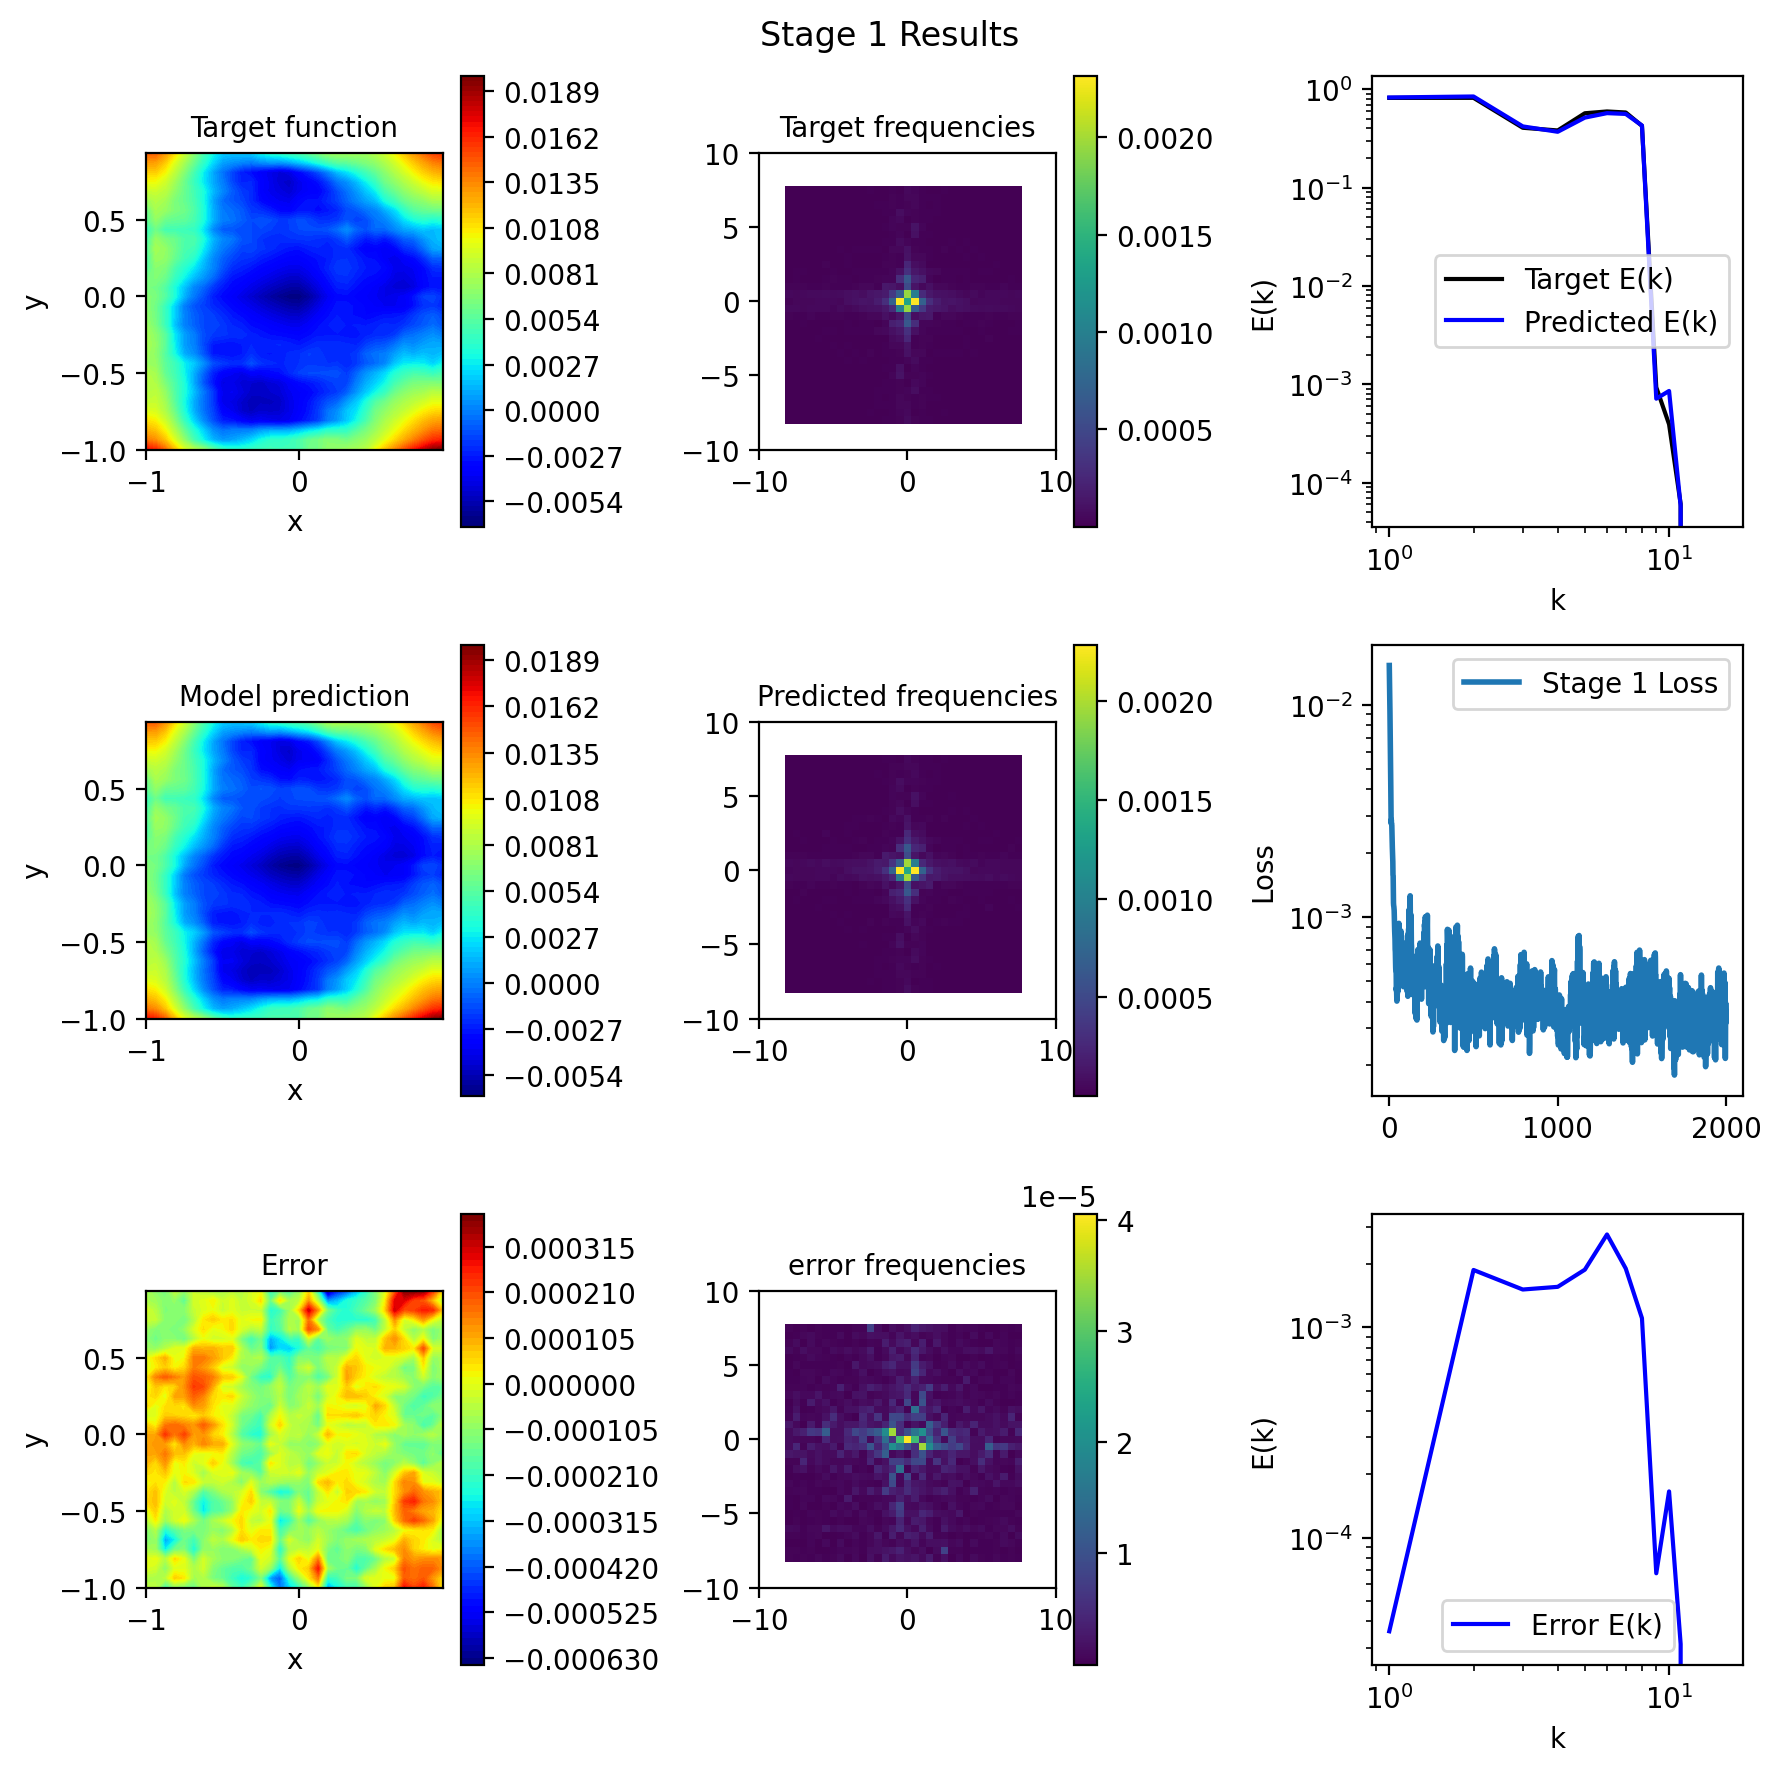

2.882841414259759e-06, 0.25424652496448796


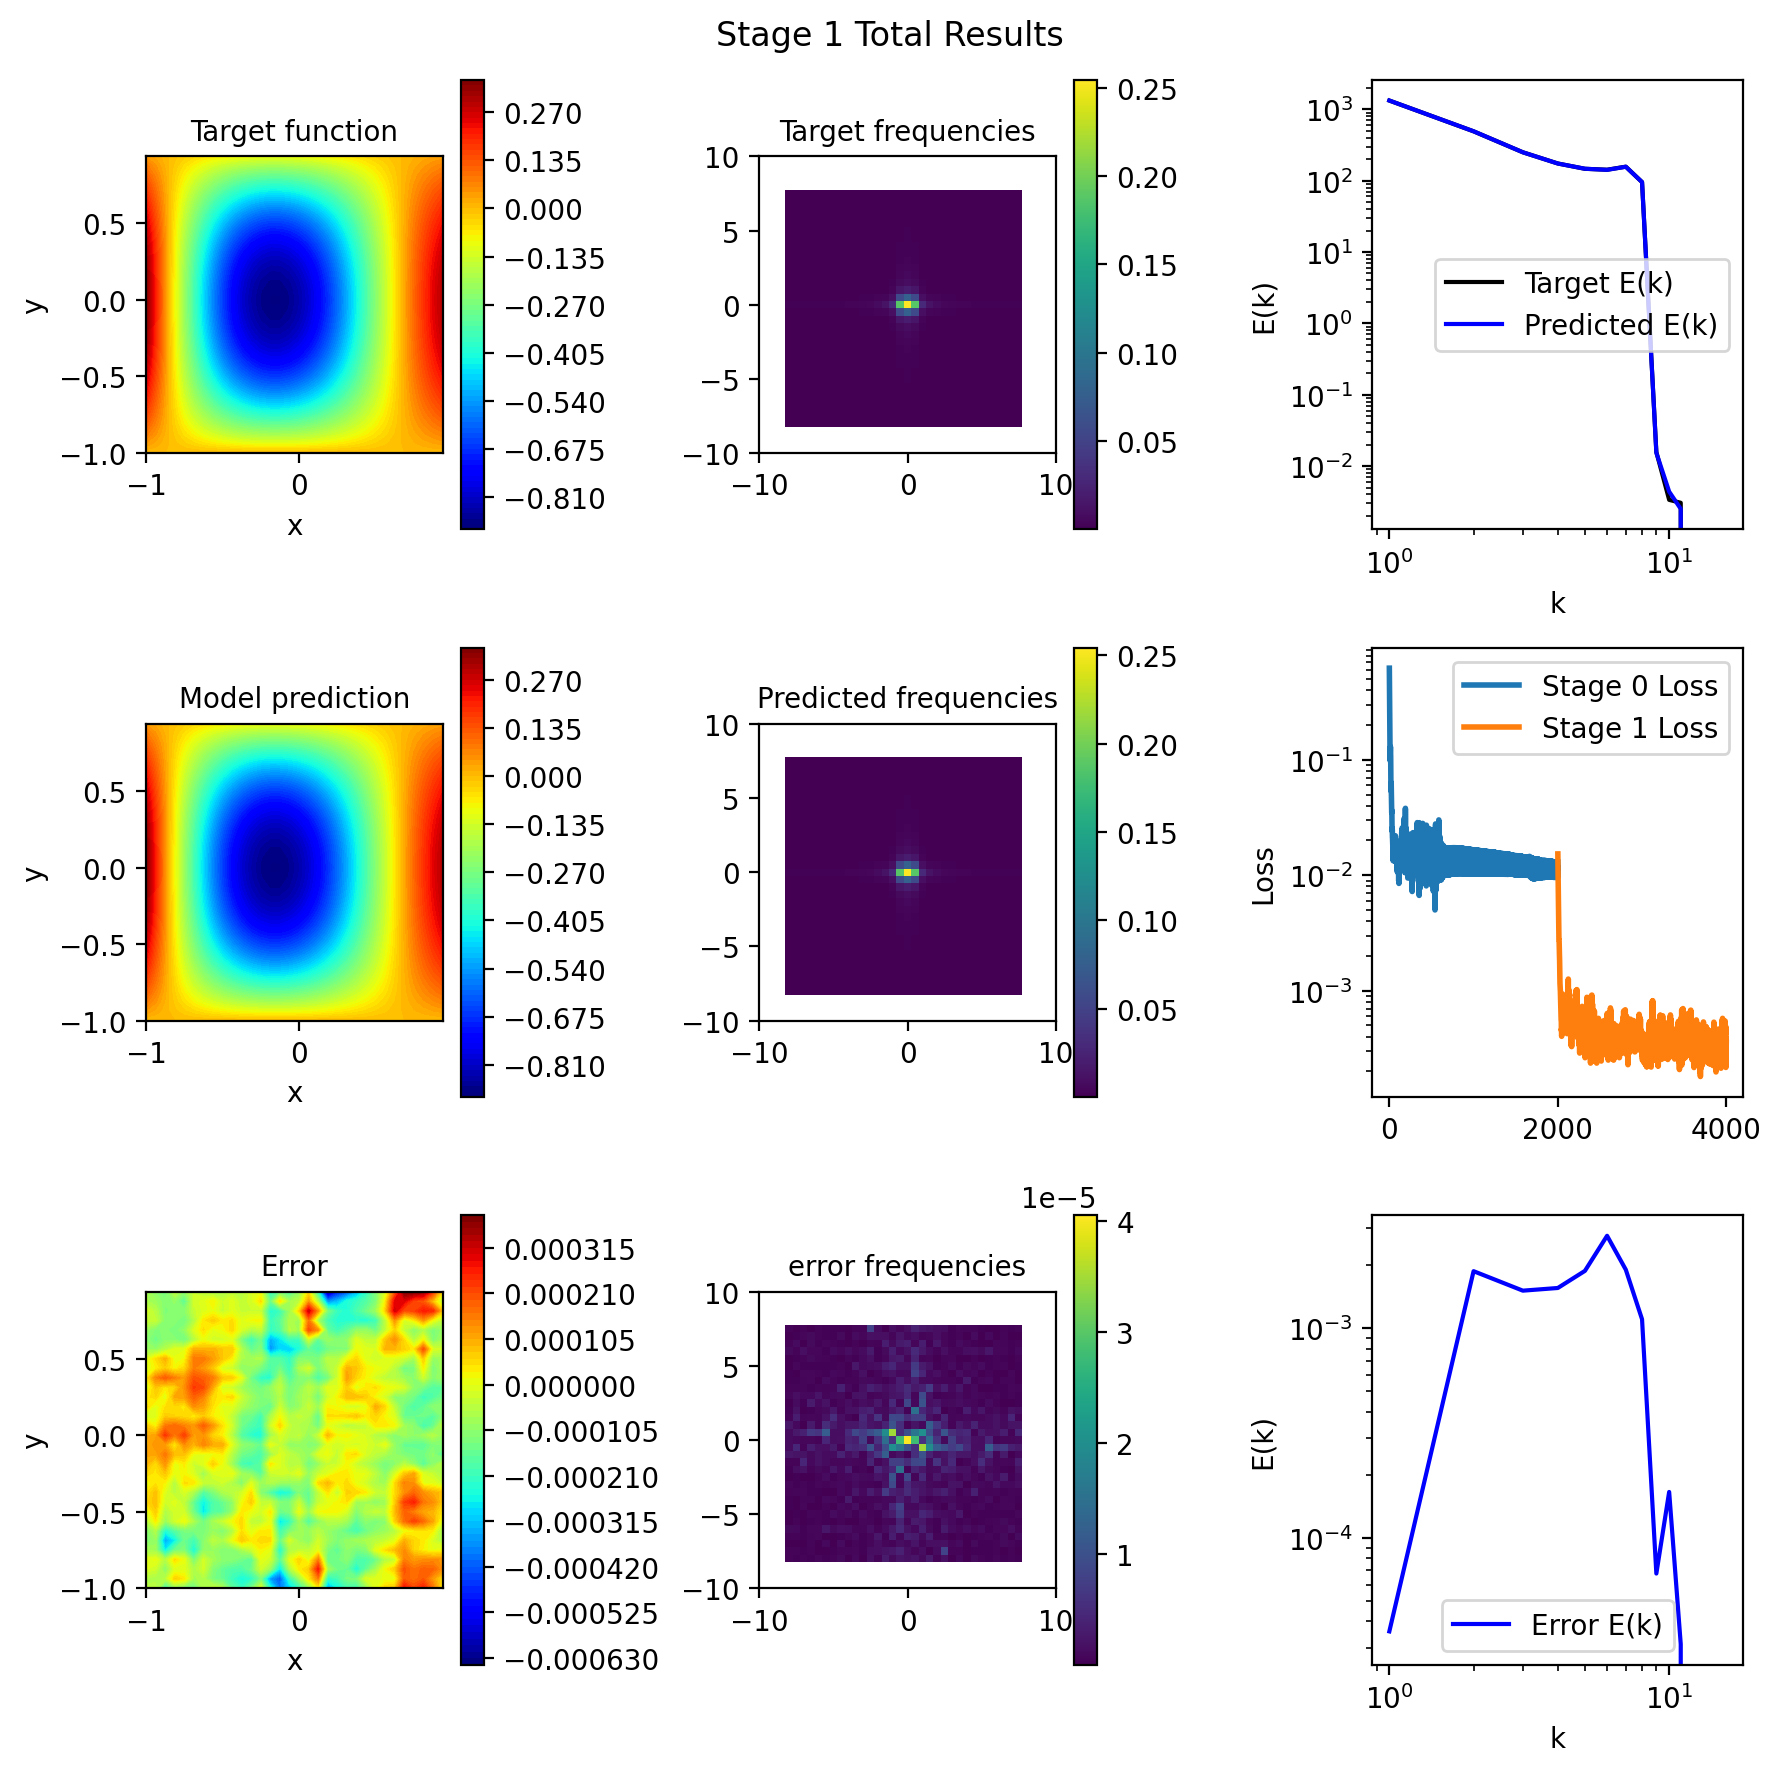

In [95]:
import sys
import math
import jax.numpy as jnp
import numpy as np
import optax
import abc
import jax
from jax import random, jit, vjp, grad, vmap, jacfwd, jacrev
from jax.numpy.linalg import lstsq
from jax.flatten_util import ravel_pytree
# from customSampling import colloc2Dgrid_set, gaussian2D_smooth
import time
import functools
from scipy.io import savemat, loadmat
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

# find the root directory
cluster = False
if cluster:
    rootdir = Path(__file__).parent
else:
    rootdir = Path("/content/drive/MyDrive/Stanford/2024_04_02")
# change JAX to double precision
jax.config.update('jax_enable_x64', True)

# initialize the neural network weights and biases
def init_MLP(parent_key, layer_widths):
    params = []
    keys = random.split(parent_key, num=len(layer_widths) - 1)
    # create the weights and biases for the network
    for in_dim, out_dim, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = random.split(key)
        xavier_stddev = jnp.sqrt(2 / (in_dim + out_dim))
        weights = random.truncated_normal(weight_key, -2, 2, shape=(in_dim, out_dim)) * xavier_stddev
        # if out_dim == 1:
        #     weights = jnp.ones((in_dim, out_dim))
        # print(f"{jnp.std(weights)=}, {xavier_stddev=}")
        biases = random.truncated_normal(bias_key, -2, 2, shape=(out_dim,)) * 0
        params.append(
            [weights,
             biases]
        )
    return params

# define the basic formation of neural network
def neural_net(params, z, limit, scl=60, act_s=1):
    '''
    :param params: weights and biases
    :param x: input data [matrix with shape [N, m]]; m is number of inputs)
    :param limit: characteristic scale for normalization [matrx with shape [2, m]]
    :param sgn:  1 for even function and -1 for odd function
    :return: neural network output [matrix with shape [N, n]]; n is number of outputs)
    '''
    lb = limit[0]  # lower bound for each input
    ub = limit[1]  # upper bound for each input

    # choose the activation function
    actv = [jnp.tanh, jnp.sin][act_s]
    # normalize the input
    H = 2.0 * (z - lb) / (ub - lb) - 1.0
    # separate the first, hidden and last layers
    first, *hidden, last = params
    # calculate the first layers output with right scale
    H = actv(jnp.dot(H, first[0]) * scl + first[1])
    # calculate the middle layers output
    for layer in hidden:
        H = jnp.tanh(jnp.dot(H, layer[0]) + layer[1])
    # no activation function for last layer
    var = jnp.dot(H, last[0]) + last[1]
    return var

# define the basic formation of neural network
# multiply output by net_scl
def fourier_net(params, z, limit, act_s, net_scl):
    '''
    :param params: weights and biases
    :param x: input data [matrix with shape [N, m]]; m is number of inputs)
    :param limit: characteristic scale for normalizeation [matrix with shape [2, m]]
    :return: neural network output [matrix with shape [N, n]]; n is number of outputs)
    '''
    lb = limit[0]  # lower bound for each input
    ub = limit[1]  # upper bound for each input

    actv = [jnp.tanh, jnp.cos][act_s]
    # normalize the input
    H = 2.0 * (z - lb) / (ub - lb) - 1.0
    # separate the first, hidden and last layers
    first, *hidden, last = params
    # calculate the first layers output with right scale
    H = actv(jnp.dot(H, first[0]) * 2*np.pi + first[1]) * Ps_scl
    Phi = jnp.sum(H, axis = 1, keepdims = True)

    # calculate the middle layers output
    max_width = 31
    for layer in hidden:
        # result0 = jnp.dot(H[:, :max_width], layer[0][:max_width])
        # for i in range(1, math.ceil(layer[0].shape[0] / max_width)):#int(jnp.ceil(layer[0].shape[0] / max_width))):
        #     result0 = result0 + jnp.dot(H[:, i * max_width : (i + 1) * max_width], layer[0][i * max_width : (i + 1) * max_width])
        # H = jnp.tanh(result0 + layer[1])
        result = jnp.dot(H, layer[0])
        H = jnp.tanh(result + layer[1])
    # no activation function for last layer
    # var = jnp.dot(H, jnp.ones([Ps.size, 1]))
    var = jnp.dot(H, last[0]) + last[1]
    # if len(first) == 3:
    #     alpha = first[2]
    #     return net_scl * (alpha * var + (1 - alpha) * Phi)
    # else:
    return var * net_scl

# generate weights and biases for all variables
def sol_init_MLP(parent_key, layers):#n_hl, n_unit):
    '''
    :param n_hl: number of hidden layers [int]
    :param n_unit: number of units in each layer [int]
    '''
    # layers = [Ps.size] + n_hl * [n_unit] + [1]
    # generate the random key for each network
    keys = random.split(parent_key, 1)
    # generate weights and biases for
    params_u = init_MLP(keys[0], layers)
    return params_u

# wrapper to create solution function with given domain size
def sol_pred_create(limit, layers, act_s=1, net_scl = 1): # default activation is cos
    '''
    :param limit: domain size of the input
    :return: function of the solution (a callable)
    '''
    def f_u(params, z):
        # generate the NN
        u = fourier_net(params, z, limit, act_s, net_scl)
        return u
    return f_u

def mNN_pred_create(f_u, limit, scl, epsil, act_s=0):
    '''
    :param f_u: sum of previous stage network
    :param limit: domain size of the input
    :return: function of the solution (a callable)
    '''
    def f_comb(params, z):
        # generate the NN
        u_now = neural_net(params, z, limit, scl, act_s)
        u = f_u(z) + epsil * u_now
        return u
    return f_comb

"""Low-level functions developed for PINN training using JAX"""

# # define the mean squared error
# def ms_error(diff):
#     return jnp.mean(jnp.square(diff), axis=0)

"""Low-level functions developed for PINN training using JAX"""
def lp2_error(diff, p):
    # Returns (1/N * sum(|diff|^p))^(1/p) so it has the same order of magnitude as the RMSE
    loss = jnp.power(jnp.mean(jnp.power(jnp.abs(diff), p), axis = 0), 1 / p)
    return loss

# generate matrix required for vjp for vector gradient
def vgmat(z, n_out, idx=None):
    '''
    :param n_out: number of output variables
    :param idx: indice (list) of the output variable to take the gradient
    '''
    if idx is None:
        idx = range(n_out)
    # obtain the number of index
    n_idx = len(idx)
    # obtain the number of input points
    n_pt = z.shape[0]
    # determine the shape of the gradient matrix
    mat_shape = [n_idx, n_pt, n_out]
    # create the zero matrix based on the shape
    mat = jnp.zeros(mat_shape)
    # choose the associated element in the matrix to 1
    for l, ii in zip(range(n_idx), idx):
        mat = mat.at[l, :, ii].set(1.)
    return mat


# vector gradient of the output with with input
def vectgrad(func, z):
    # obtain the output and the gradient function
    sol, vjp_fn = vjp(func, z)
    # determine the mat grad
    mat = vgmat(z, sol.shape[1])
    # calculate the gradient of each output with respect to each input
    grad_sol = vmap(vjp_fn, in_axes=0)(mat)[0]
    # calculate the total partial derivative of output with input
    n_pd = z.shape[1] * sol.shape[1]
    # reshape the derivative of output with input
    grad_all = grad_sol.transpose(1, 0, 2).reshape(z.shape[0], n_pd)
    return grad_all, sol


def loss_create(predf_u, loss_ref, p = 2):
    '''
    a function factory to create the loss function based on given info
    :param loss_ref: loss value at the initial of the training
    :return: a loss function (callable)
    '''
    def res_fun(params, data):
        # load the position and weight of collocation points
        z_c = data['xy']
        u_c = data['u']
        # create the function for gradient calculation involves input Z only
        f_u = lambda z: predf_u(params, z)
        u_p = f_u(z_c)
        res = (u_p - u_c)[:, 0]
        return res

    # loss function used for the PINN training
    def loss_fun(params, data):

        # load the position and weight of collocation points
        z_c = data['xy']
        u_c = data['u']

        # create the function for gradient calculation involves input Z only
        f_u = lambda z: predf_u(params, z)
        u_p = f_u(z_c)

        # load the hyper-parameter
        lref = loss_fun.ref

        # calculate the mean squared root error of normalization cond.
        data_err = lp2_error(u_p - u_c, p)

        # calculate the total loss
        loss = jnp.sum(data_err)
        loss_n = loss / lref
        # group the loss of all conditions and equations
        loss_info = jnp.array([lref, loss])
        return loss_n, loss_info

    loss_fun.ref = loss_ref
    return loss_fun, res_fun

#%%

# create the Adam minimizer
@functools.partial(jit, static_argnames=("lossf", "opt"))
def adam_minimizer(lossf, params, data, opt, opt_state):
    """Basic gradient update step based on the opt optimizer."""
    grads, loss_info = grad(lossf, has_aux=True)(params, data)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, loss_info, opt_state

def SNR_collect(lossf, params, data, key):
    """Basic gradient update step based on the opt optimizer."""
    # re-sampling the data points
    minibatch = 100
    u_shuffle = random.permutation(key, data['u'])
    xy_shuffle = random.permutation(key, data['xy'])
    if u_shuffle.shape[0] % minibatch != 0:
        u_shuffle = u_shuffle[:-1 * (u_shuffle.shape[0] % minibatch)]
        xy_shuffle = xy_shuffle[:-1 * (xy_shuffle.shape[0] % minibatch)]
    u_minibatch = jnp.array(jnp.split(u_shuffle, minibatch))
    xy_minibatch = jnp.array(jnp.split(xy_shuffle, minibatch))
    data_minibatch = {'u': u_minibatch, 'xy': xy_minibatch}
    grads, loss_info = jax.vmap(grad(lossf, has_aux=True), in_axes = (None, 0))(params, data_minibatch)
    params_info = [params, grads]
    return params_info

def adam_optimizer(key, lossf, params, dataf, F0, epoch, lr=1e-3, mode=0, snr_every=50):
    testing = False
    # select the Adam as the minimizer
    opt_Adam = optax.adam(learning_rate=lr)
    # obtain the initial state of the params
    opt_state = opt_Adam.init(params)
    # pre-allocate the loss varaible
    loss_all = []
    loss_return = []
    data = dataf(key, F0)
    new_key = random.split(key, 1)[0]
    snr_key = random.split(new_key, 1)[0]

    nc = jnp.int32(jnp.round(epoch / 5))
    nc0 = 2500
    # start the training iteration

    # gradf = grad(lossf, has_aux=True) # gradient function, takes in (params, data)
    step = 0
    while step < epoch:
        # minimize the loss function using Adam
        params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
        # print the loss for every 100 iteration
        if step % 100 == 0:
            print(f"Step: {step} | Loss: {loss_info[1]:.4e}", file=sys.stderr)
            new_key = random.split(key, 1)[0]
        elif (step+1) % 500 == 0:
            Fnew = predictF(params, dataf.X, dataf.Y)
            data = dataf(new_key, Fnew)

        if step % snr_every == 0 and mode == 1:
            snr_key = random.split(snr_key, 1)[0]
            params_info = SNR_collect(lossf, params, data, snr_key)
            # saving the data points
            print(f"the file name should be {description}_params_iter{step}.pkl")

            with open(f"{description}_params_iter{step}.pkl", 'wb') as f:
                # The protocol version used is detected automatically, so we do not
                # have to specify it.
                pickle.dump(params_info, f, pickle.HIGHEST_PROTOCOL)

        # saving the loss
        loss_all.append(loss_info[1:])
        loss_return.append(loss_info[1].item())

        if (step+1) % (2*nc0) == 0:
            lossend = np.array(loss_all[-2 * nc0:])[:, 0]
            lc1 = lossend[0: nc0]
            lc2 = lossend[nc0:]
            mm12 = jnp.abs(jnp.mean(lc1) - jnp.mean(lc2))
            stdl2 = jnp.std(lc2)
            # if the average loss improvement within 'nc' iteration is less than local loss fluctuation (std)
            if mm12 / stdl2 < 0.4:
                # reduce the learning rate by half
                lr = lr / 2
                opt_Adam = optax.adam(learning_rate=lr)
            print(f"learning rate for Adam: {lr:.4e} | mean: {mm12:.3e} | std: {stdl2:.3e}", file=sys.stderr)
         # calculate snr every n_snr iterations
        step += 1

    # obtain the total loss in the last iterations
    lossend = jnp.array(loss_all[-nc:])[:, 0]
    # find the minimum loss value
    lmin = jnp.min(lossend)
    # optain the last loss value
    llast = lossend[-1]
    # guarantee the loss value in last iteration is smaller than anyone before
    if not testing:
        for lc in range(2 * nc0):
            if llast < lmin:
                break
            params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
            llast = loss_info[0]
            # saving the loss
            loss_all.append(loss_info[0:])
            loss_return.append(loss_info[1]) #TODO: check on this

            if step % 100 == 0:
                print(f"End step: {step} | Loss: {loss_info[1]:.4e}", file=sys.stderr)
                new_key = random.split(key, 1)[0]

            elif (step+1) % 500 == 0:
                Fnew = predictF(params, dataf.X, dataf.Y)
                data = dataf(new_key, Fnew)

            if step % snr_every == 0 and mode == 1:
                snr_key = random.split(snr_key, 1)[0]
                params_info = SNR_collect(lossf, params, data, snr_key)
                # saving the data points
                with open(f"{description}_params_iter{step}.pkl", 'wb') as f:
                    # The protocol version used is detected automatically, so we do not
                    # have to specify it.
                    pickle.dump(params_info, f, pickle.HIGHEST_PROTOCOL)
            step += 1

    print(f"Step: final | Loss: {loss_info[1]:.4e}", file=sys.stderr)

    return params, loss_return #, signal, noise, snr #loss_all

def gram_factory(v_residual):
    def gramian(params, data):
        # flatten params to enable correct jacobian compuations
        f_params, unravel = ravel_pytree(params)
        X = data['xy']
        # For long flat jacobians we use reverse mode autodiff.
        if len(f_params) > len(X):
            jac = jacrev
        # for tall slim jacobians we use forward mode autodiff.
        else:
            jac = jacfwd
        # Compute the jacobian on batched data
        J = jac(lambda f_params, x: v_residual(unravel(f_params), x), argnums=0)(f_params, data)

        return 1.0 / len(X) * jnp.transpose(J) @ J
    return gramian

""" If we use the natural gradient descent without damping,
then a linesearch spanning an extremly large variety of step sizes is needed.
We do this using a line search on a logarithmic grid."""

def grid_line_search_factory(loss, steps):

   def loss_at_step(step, data, params, tangent_params):
      updated_params = [(w - step * dw, b - step * db)
          for (w, b), (dw, db) in zip(params, tangent_params)]
      return loss(updated_params, data)[0]

   v_loss_at_steps = jit(vmap(loss_at_step, (0, None, None, None)))

   @jit
   def grid_line_search_update(params, data, tangent_params):
      losses = v_loss_at_steps(steps, data, params, tangent_params)
      step_size = steps[jnp.argmin(losses)]
      return [(w - step_size * dw, b - step_size * db)
              for (w, b), (dw, db) in zip(params, tangent_params)], step_size

   return grid_line_search_update

def ENG_optimizer(key, lossf, res_fun, params, dataf, epoch, div0):
    # set up grid line search
    grid = jnp.linspace(0, 30, 31)
    steps = 0.5**grid
    # gramian assembly requires flat parameters
    f_params, unravel = ravel_pytree(params)
    # create gramian initialization function
    gram_int = jit(gram_factory(res_fun))
    # sample the dataset
    data = dataf(key)
    new_key = random.split(key, 1)[0]
    # set the initial damping
    damping = 1e-1
    div = div0

    loss_all = []
    step_all = []

    for iter in range(epoch):
        # compute gradient of loss
        grads, loss_info = grad(lossf, has_aux=True)(params, data)
        f_grads = ravel_pytree(grads)[0]

        # calculate and save the current loss
        loss_now = loss_info[1] / loss_info[0]
        loss_all.append(loss_now)

        # assemble gramian
        G = gram_int(params, data)

        # Marquardt-Levenberg (add damping effect)
        Id = jnp.identity(len(G))
        # G = jnp.max(jnp.array([loss_now, damping])) * Id + G
        G = damping * Id + G

        # compute natural gradient
        f_nat_grad = lstsq(G, f_grads, rcond=-1)[0]
        nat_grad = unravel(f_nat_grad)

        ls_update = grid_line_search_factory(lossf, steps)
        # one step of NGD
        params, actual_step = ls_update(params, data, nat_grad)
        step_all.append(actual_step)

        if iter == 0:
            loss0 = loss_now
            iter0 = 0

        if (iter+1) % 100 == 0 and iter > epoch-220:
            new_key = random.split(new_key, 1)[0]
            Fs = predictF(params, dataf.X, dataf.Y)
            data = dataf(new_key, Fs)
            plt.scatter(dataf.X, dataf.Y, c=Fs, s=10)
            plt.gca().set_aspect(1.)
            plt.gca().title.set_text('Fs')
            plt.colorbar()
            plt.show()
            colpoint_plot(X*0, data['xy'], [-1, 1, -1, 1], ['collo. point', '$R$', '$\theta$'])
            div = 0.0001
            damping = loss_now / div
            loss0 = loss_now

        if (iter + 1) % 5 == 0:
            print(
                f'NG Iteration: {iter + 1} with loss: {loss_info[1]:.4e} and'
                f' step: {actual_step:.4e} and damping: {damping:.4e}'
            )
            ratio_loss = loss_now / loss0
            if iter < 20:
                if ratio_loss < 0.1 and actual_step > 0.02:
                    damping = loss_now / div
                    loss0 = loss_now
                    iter0 = iter
            elif iter >= 20:
                if (ratio_loss < 0.1 and actual_step > 0.02) or (ratio_loss < 0.5 and actual_step > 0.1):
                    ratio_step = step_all[-1] / step_all[-6]
                    ratio_dloss = loss_all[-1] * loss_all[-11] / loss_all[-6] ** 2
                    if ratio_step < 1 or ratio_dloss >= 4:
                        gain = -jnp.log10(ratio_loss) / (iter - iter0)
                        div = jnp.max(jnp.array([2, 6 + 2*jnp.log10(gain)]))
                        damping /= div
                        loss0 = loss_now

    return params, loss_all

#%%
def data_eqsp2D(ds, ns):
    '''
    :param ds:  size of domain in the r direction
    :param ns:  number of grid in each dimension len = 2
    '''
    x = jnp.linspace(ds[0], ds[1], ns[0])
    y = jnp.linspace(ds[0], ds[1], ns[1])
    X, Y = jnp.meshgrid(x, y)
    return X, Y


"""Prepare the data points"""
def data_func_create(N_col, N_bd = 10000, use_all = False):
    # define the function that can re-sampling for each calling
    # Domain bounds

    bd = 0.95
    idx_in = jnp.where((x_star < bd) & (x_star > -bd) & (y_star < bd) & (y_star > -bd))[0] # Within boundaries
    idx_out = jnp.where((x_star >= bd) | (x_star <= -bd) | (y_star >= bd) | (y_star <= -bd))[0] # Outside of boundaries
    F0 = X * 0 + 1

    def dataf(key, F):
        if use_all:
            return dict(xy = xy_star, u = u_star)
        else:
            # generate the subkey for each group
            new_keys = jax.random.split(key, 4)
            # fix distribution collocation point
            idx_c = jax.random.choice(new_keys[0], idx_in, (N_col[0],), replace=False) # collocation points
            idx_b = jax.random.choice(new_keys[1], idx_out, (N_bd,), replace=False) # boundary points
            idx_add = colloc2Dgrid_set(new_keys[2], X, Y, F, N_col[1])
            idx_all = jnp.hstack([idx_c, idx_b, idx_add])
            xy = xy_star[idx_all]
            u_c = u_star[idx_all]
            return dict(xy=xy, u=u_c)

    dataf.X = X
    dataf.Y = Y
    return dataf, F0


# plot the collocation point
def colpoint_plot(U, X_col, limit, fig_str):
    # limit = [x1min, x1max, x1min, x2max]
    # fig_str = ['title', 'xlabel', 'yabel']

    fig = plt.figure(figsize=[12, 10], dpi=100)

    ax = plt.subplot()
    h = ax.imshow(U, interpolation='nearest', cmap='rainbow',
                  extent=limit, origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(X_col[:, 0], X_col[:, 1], 'kx', markersize=5, clip_on=False)
    ax.set_title(fig_str[0], fontsize=15)
    ax.set_xlabel(fig_str[1], fontsize=15)
    ax.set_ylabel(fig_str[2], fontsize=15, rotation=0)
    plt.show()


def predictF(params, z1, z2):
    # create the output function
    fsol = lambda z: pred_u(params, z)
    # generate the input for network
    z_star = jnp.hstack((z1.flatten()[:, None], z2.flatten()[:, None]))
    # calculate the equation residue
    f0 = fsol(z_star) - u_star

    # calculate the maximum of the square of residue for all equations
    f_sq = jnp.vstack(jnp.abs(f0))**1.5
    # normalize the distribution function and add a basic level
    f_nm = f_sq / jnp.mean(f_sq) + 0.5
    # create the 2D distribution function F
    F = jnp.reshape(f_nm, z1.shape)
    # smooth the weight function by Gaussian filter
    Fs = gaussian2D_smooth(F, [1, 1], [5, 5])
    return Fs

"""Set the conditions of the problem"""
# select the random seed
seed = 1234
key = random.PRNGKey(seed)
np.random.seed(seed)
test = 3
fourier_init = True

# create the subkeys
keys = random.split(key, 8)

# select the size of neural network
n_hl = 3
n_unit = 30
# n_hl = 1
# n_unit = 10
scl = 1
lmt = jnp.array([[-1], [1]])
p = 10
act_s = 1

# number of sampling points
N_col = jnp.int32([2.5e4, 2.5e4])

# set the training iteration
epoch1 = 2000

if test == 1:
    if cluster:
        FileName = 'Reg_ENG_exp2.mat'
    else:
        FileName = '/content/drive/MyDrive/Stanford/2024_04_02/Reg_ENG_exp2.mat'
    data = loadmat(FileName)
    X = data['X']
    Y = data['Y']
    U = data['e']

# U = jnp.sin(2*np.pi*(2*X+Y))   # other simple examples to test
# U = jnp.exp(-Y**2)
# U = X
if test == 2:
    if cluster:
        FileName = "N=512_Re=2000_mcwilliams_save_every=16000_num_steps=1.npz"
    else:
        FileName = "/content/drive/MyDrive/Stanford/2024_04_02/N=512_Re=2000_mcwilliams_save_every=16000_num_steps=1.npz"
    endpoint = False
    N_x = 512
    N_y = 512
    lb = [-1, -1]
    ub = [1, 1]
    limit = jnp.array([lb, ub])
    x = jnp.linspace(-1, 1, N_x, endpoint = endpoint) #jnp.linspace(0, 1, N_x)
    y = jnp.linspace(-1, 1, N_y, endpoint = endpoint) #jnp.linspace(-1, 1, N_y)
    X, Y = jnp.meshgrid(x, y)
    U = jnp.load(FileName)['psi'][-1]

if test == 3:
    endpoint = False
    N_x = 100
    N_y = 100
    N_x = 32
    N_y = 32
    lb = [-1, -1]
    ub = [1, 1]
    limit = jnp.array([lb, ub])
    x = jnp.linspace(-1, 1, N_x, endpoint = endpoint) #jnp.linspace(0, 1, N_x)
    y = jnp.linspace(-1, 1, N_y, endpoint = endpoint) #jnp.linspace(-1, 1, N_y)
    X, Y = jnp.meshgrid(x, y)
    # U = 3 * jnp.sin(2 * np.pi * X + 3 * Y + 3) * (1 - X ** 2)
    # U = jnp.sin(X)
    U = (jnp.sin(2 * X - 1) - 0.5 * X) * (1 - Y ** 2)

if test == 4:
    endpoint = False
    N_x = 512
    N_y = 512
    lb = [-1, -1]
    ub = [1, 1]
    limit = jnp.array([lb, ub])
    x = jnp.linspace(-1, 1, N_x, endpoint = endpoint) #jnp.linspace(0, 1, N_x)
    y = jnp.linspace(-1, 1, N_y, endpoint = endpoint) #jnp.linspace(-1, 1, N_y)
    X, Y = jnp.meshgrid(x, y)
    if cluster:
        U = loadmat("~/summer_pinn/2024_04_09/reg2d_test2_p10_iters150000_stage3_fourinitTrue_act1_10000_results.mat")['e']
    else:
        U = loadmat("/content/drive/MyDrive/Stanford/2024_04_06/reg2d_test2_p10_iters50000_stage1_fourinitTrue_act1_3000_residual.mat")['residual']
U_0 = U
n_stages = 2
U_p_stages = [] # list of all the predicted Us for each stage
eps_stages = [] # epsilon for each stage
loss_stages = [] # list of all losses
descriptions = [] # filenames
for stage in range(n_stages):
    eps = jnp.max(U)
    U = U / eps
    x_star = X.flatten()[:, jnp.newaxis]
    y_star = Y.flatten()[:, jnp.newaxis]
    u_star = U.flatten()[:, jnp.newaxis]
    xy_star = jnp.hstack((x_star, y_star))

    w = jnp.fft.fft2(U)
    w = w.at[1::2, :].set(w[1::2, :]*jnp.exp(1j*np.pi))  # shift the solution by half period
    w = w.at[:, 1::2].set(w[:, 1::2]*jnp.exp(1j*np.pi))  # shift the solution by half period

    timestep = jnp.array([N_x, N_y]) / (limit[1] - limit[0])
    freq_x = jnp.fft.fftfreq(n = N_x, d = 1 / timestep[0]) # frequency in multiples of 1/pi cycles/second
    freq_y = jnp.fft.fftfreq(n = N_y, d = 1 / timestep[1])
    plt.figure()
    h = plt.pcolormesh(jnp.fft.fftshift(freq_x), jnp.fft.fftshift(freq_y), np.abs(jnp.fft.fftshift(w)), shading = 'auto')
    plt.colorbar(h)
    plt.show()
    plt.close('all')

    # ax = fig.add_subplot(3, 3, 2)
    # timestep = jnp.array([N_x, N_y]) / (limit[1] - limit[0])
    # freq_x = jnp.fft.fftshift(jnp.fft.fftfreq(n = N_x, d = 1 / timestep[0])) # frequency in multiples of 1/pi cycles/second
    # freq_y = jnp.fft.fftshift(jnp.fft.fftfreq(n = N_y, d = 1 / timestep[1]))
    # norm = 'forward'
    # FS = jnp.fft.fftn(u_target, norm = norm)
    # FS_abs = np.abs(np.fft.fftshift(FS))
    # h = ax.pcolormesh(freq_x, freq_y, np.abs(np.fft.fftshift(FS)), shading = "auto")
    # plt.colorbar(h, ax = ax)

    # L = N_x             # Length of signal
    # Fs = L/2            # Sampling frequency
    # f1 = Fs * jnp.hstack([jnp.arange(0, L/2+1), jnp.arange(-L/2+1, 0)])/L
    # F1, F2 = jnp.meshgrid(f1, f1)
    # F11, F21 = jnp.meshgrid(freq_x, freq_y)
    # print(f"{jnp.all(F1==F11)=}")
    # plt.figure()
    # h = plt.pcolormesh(F1 - F11, shading = 'auto')
    # plt.colorbar(h)
    # plt.show()
    # plt.close('all')

    FX, FY = jnp.meshgrid(freq_x, freq_y)

    ds = 200
    wc = jnp.hstack([w[0:ds, -ds+1:], w[0:ds, 0:ds]])
    wc = wc.at[0:1, :].set(wc[0:1, :]/2)
    F1c = jnp.hstack([FX[0:ds, -ds+1:], FX[0:ds, 0:ds]])
    F2c = jnp.hstack([FY[0:ds, -ds+1:], FY[0:ds, 0:ds]])

    P2c = jnp.abs(wc/N_x**2*2)
    A2c = jnp.angle(wc/N_x**2*2)

    P_1d = P2c.flatten()
    A_1d = A2c.flatten()
    F1_1d = F1c.flatten()
    F2_1d = F2c.flatten()

    idx = jnp.flip(jnp.argsort(P_1d))
    Ps = P_1d[idx]
    # idxElim = jnp.where(Ps < 0)[0] #
    idxElim = jnp.where(Ps < Ps[0]*0.0001)[0]
    idxs = jnp.delete(idx, idxElim)

    Ps = P_1d[idxs]
    As = A_1d[idxs]
    F1s = F1_1d[idxs]
    F2s = F2_1d[idxs]

    # determine the number of modes you need
    nmode = jnp.min(jnp.array([10000, Ps.size]))
    print(f"{nmode=}")
    Ps = Ps[:nmode][jnp.newaxis,:]
    As = As[:nmode][jnp.newaxis,:]
    F1s = F1s[:nmode][jnp.newaxis,:]
    F2s = F2s[:nmode][jnp.newaxis,:]

    wgh0_s = jnp.vstack([F1s, F2s])
    bia0_s = As
    first_params = [wgh0_s, bia0_s]
    Ps_scl = Ps / jnp.max(Ps) # TODO: ask why we do jnp.max(Ps)

    alpha = None
    #%% second stage training
    if alpha is not None:
        first_params.append(alpha)

    if fourier_init:
        # initialize the weights and biases of the network
        layers = [Ps.size] + n_hl * [n_unit] + [1]
        print(f"{layers=}")
        trained_params0 = sol_init_MLP(keys[5], layers)# n_hl, n_unit)
        trained_params = [first_params] + trained_params0
    else:
        layers = [2] + [Ps.size] + n_hl * [n_unit] + [1]
        trained_params = sol_init_MLP(keys[5], layers) #n_hl, n_unit)

    # create the solution function
    pred_u = sol_pred_create(lmt, layers = layers, act_s = act_s)
    # create the data function
    dataf, F0 = data_func_create(N_col, use_all = True)

    F = predictF(trained_params, dataf.X, dataf.Y)
    data = dataf(keys[4], F)
    # colpoint_plot(F, data['xy'], [-1, 1, -1, 1], ['collo. point', '$R$', '$\theta$'])

    # create the solution function
    f_u = lambda z: pred_u(trained_params, z)
    u_p = f_u(xy_star)
    U_p = jnp.reshape(u_p, X.shape)
    net_scl = 1 / jnp.max(U_p)
    print(f"{net_scl=}")

    # create the solution function
    pred_u = sol_pred_create(lmt, layers = layers, act_s = act_s, net_scl = net_scl)
    f_u = lambda z: pred_u(trained_params, z)
    u_p = f_u(xy_star)
    U_p = jnp.reshape(u_p, X.shape)

    # calculate the loss function
    NN_loss, res_fun = loss_create(pred_u, loss_ref=1, p = p)
    NN_loss.ref = NN_loss(trained_params, data)[1][1]

    if cluster:
        folder = f'2024_04_06'
        description = f'{folder}/reg2d_test{test}_p{p}_iters{epoch1}_stage{stage}_fourinit{fourier_init}_act{act_s}_nmode{nmode}'
    else:
        folder = f'/content/drive/MyDrive/Stanford/2024_04_17'
        description = f'{folder}/reg2d_test{test}_p{p}_iters{epoch1}_stage{stage}'
    descriptions.append(description)
    def plot_results(U, U_p, loss = None, stage = "", filename = "reg2d_results.png", title = "Results"):
        U = U
        U_p = U_p
        dpi = 200
        fig = plt.figure(figsize = [9, 9], dpi = dpi)

        u_target = U.reshape(N_y, N_x)
        u_pred = U_p.reshape(N_y, N_x)
        u_min = min(jnp.min(u_target), jnp.min(u_pred))
        u_max = max(jnp.max(u_target), jnp.max(u_pred))
        error = u_target - u_pred
        err_min = jnp.min(error)
        err_max = jnp.max(error)
        axis_fontsize = 10

        # Target
        ax = fig.add_subplot(3, 3, 1)
        ax.set_xlabel('x', fontsize = axis_fontsize)
        ax.set_ylabel('y', fontsize = axis_fontsize)
        ax.set_title('Target function', fontsize = axis_fontsize)
        ax.set_aspect('equal')
        h = ax.contourf(X, Y, u_target, levels = 100, cmap = 'jet', vmin = u_min, vmax = u_max)
        plt.colorbar(h, ax = ax)

        # Plot model prediction
        ax = fig.add_subplot(3, 3, 4)
        ax.set_xlabel('x', fontsize = axis_fontsize)
        ax.set_ylabel('y', fontsize = axis_fontsize)
        ax.set_title(f'Model prediction', fontsize = axis_fontsize)
        h = ax.contourf(X, Y, u_pred, levels = 100, cmap = 'jet', vmin = u_min, vmax = u_max)
        ax.set_aspect('equal')
        plt.colorbar(h, ax = ax)

        # Plot error
        ax = fig.add_subplot(3, 3, 7)
        ax.set_xlabel('x', fontsize = axis_fontsize)
        ax.set_ylabel('y', fontsize = axis_fontsize)
        ax.set_title('Error', fontsize = axis_fontsize)
        h = ax.contourf(X, Y, error, levels = 100, cmap = 'jet', vmin = err_min, vmax = err_max)
        ax.set_aspect('equal')
        plt.colorbar(h, ax = ax)

        # Frequencies of actual solution
        ax = fig.add_subplot(3, 3, 2)
        timestep = jnp.array([N_x, N_y]) / (limit[1] - limit[0])
        freq_x = jnp.fft.fftshift(jnp.fft.fftfreq(n = N_x, d = 1 / timestep[0])) # frequency in multiples of 1/pi cycles/second
        freq_y = jnp.fft.fftshift(jnp.fft.fftfreq(n = N_y, d = 1 / timestep[1]))
        norm = 'forward'
        FS = jnp.fft.fftn(u_target, norm = norm)
        FS_abs = np.abs(np.fft.fftshift(FS))
        h = ax.pcolormesh(freq_x, freq_y, np.abs(np.fft.fftshift(FS)), shading = "auto")
        plt.colorbar(h, ax = ax)

        f_max = 10
        ax.set_xlim(xmin = -1 * f_max, xmax = f_max)
        # ax.set_ylim(ymin = 0, ymax = f_max)
        ax.set_ylim(ymin = -1 * f_max, ymax = f_max)
        ax.set_title('Target frequencies', fontsize = axis_fontsize)
        ax.set_aspect('equal')

        # Frequencies of predicted solution
        ax = fig.add_subplot(3, 3, 5)
        FS = jnp.fft.fftn(u_pred, norm = norm)
        FS_abs = np.abs(np.fft.fftshift(FS))
        ax.set_aspect('equal')
        print(f"{FS_abs.min()}, {FS_abs.max()}")
        h = ax.pcolormesh(freq_x, freq_y, FS_abs, shading = "auto")#, norm = mpl.colors.LogNorm(vmin=FS_abs.min(), vmax=FS_abs.max()))
        plt.colorbar(h, ax = ax)
        ax.set_xlim(xmin = -1 * f_max, xmax = f_max)
        ax.set_ylim(ymin = -1 * f_max, ymax = f_max)
        ax.set_title('Predicted frequencies', fontsize = axis_fontsize)
        ax.set_aspect('equal')

        # Frequencies of error
        ax = fig.add_subplot(3, 3, 8)
        FS = jnp.fft.fftn(error, norm = norm)
        FS_abs = np.abs(np.fft.fftshift(FS))
        argmax = np.unravel_index(FS_abs.argmax(), FS_abs.shape)

        h = ax.pcolormesh(freq_x, freq_y, np.abs(np.fft.fftshift(FS)), shading = "auto")
        plt.colorbar(h, ax = ax)
        ax.set_xlim(xmin = -1 * f_max, xmax = f_max)
        ax.set_ylim(ymin = -1 * f_max, ymax = f_max)
        ax.set_title('error frequencies', fontsize = axis_fontsize)
        ax.set_aspect('equal')

                # Energy spectrum of actual solution
        ax = fig.add_subplot(3, 3, 3)
        KX, KY = jnp.meshgrid(freq_x, freq_y)
        k2 = KX ** 2 + KY ** 2 # wave number squared
        psihat = jnp.fft.fftshift(jnp.fft.fft2(U))
        tke = jnp.real(.5 * k2 * psihat * jnp.conj(psihat))
        kmod = jnp.sqrt(k2)
        k = jnp.arange(1, psihat.shape[0] // 2 + 1, 1, dtype=jnp.float64) # nyquist limit for this grid
        E = jnp.zeros_like(k)
        res = 200 # resolution
        dk = (jnp.max(k) - jnp.min(k)) / res

            #  binning energies with wavenumber modulus in threshold
        for i in range(len(k)):
            E = E.at[i].add(jnp.sum(tke[(kmod < k[i] + dk) & (kmod >= k[i] - dk)]))
        sum_E = jnp.sum(E)
            # angle averaged Turbulent Kinetic Energy spectrum
        ax.loglog(k, E, '-k', label = "Target E(k)")
        ax.set_xlabel("k")
        ax.set_ylabel("E(k)")
        ax.legend()

        # Energy spectrum of predicted solution
        psihat = jnp.fft.fftshift(jnp.fft.fft2(U_p))
        tke = jnp.real(.5 * k2 * psihat * jnp.conj(psihat))
        kmod = jnp.sqrt(k2)
        k = jnp.arange(1, psihat.shape[0] // 2 + 1, 1, dtype=jnp.float64) # nyquist limit for this grid
        E = jnp.zeros_like(k)
        res = 200 # resolution
        dk = (jnp.max(k) - jnp.min(k)) / res

            #  binning energies with wavenumber modulus in threshold
        for i in range(len(k)):
            E = E.at[i].add(jnp.sum(tke[(kmod < k[i] + dk) & (kmod >= k[i] - dk)]))
        sum_E = jnp.sum(E)
            # angle averaged Turbulent Kinetic Energy spectrum
        ax.loglog(k, E, '-b', label = "Predicted E(k)")
        ax.set_xlabel("k")
        ax.set_ylabel("E(k)")
        ax.legend()

        # Energy spectrum of error
        ax = fig.add_subplot(3, 3, 9)
        psihat = jnp.fft.fftshift(jnp.fft.fft2(U - U_p))
        tke = jnp.real(.5 * k2 * psihat * jnp.conj(psihat))
        kmod = jnp.sqrt(k2)
        k = jnp.arange(1, psihat.shape[0] // 2 + 1, 1, dtype=jnp.float64) # nyquist limit for this grid
        E = jnp.zeros_like(k)
        res = 200 # resolution
        dk = (jnp.max(k) - jnp.min(k)) / res

            #  binning energies with wavenumber modulus in threshold
        for i in range(len(k)):
            E = E.at[i].add(jnp.sum(tke[(kmod < k[i] + dk) & (kmod >= k[i] - dk)]))
        sum_E = jnp.sum(E)
            # angle averaged Turbulent Kinetic Energy spectrum
        ax.loglog(k, E, '-b', label = "Error E(k)")
        ax.set_xlabel("k")
        ax.set_ylabel("E(k)")
        ax.legend()


        # Loss
        if loss is not None:
            ax = fig.add_subplot(3, 3, 6)
            ax.set_ylabel("Loss", fontsize = axis_fontsize, rotation = 90)
            ax.set_yscale('log')
            n = 0
            # Plot loss, labeled by optimization method
            for i, loss_i in enumerate(loss):
                n_iter = len(loss_i)
                if len(loss) == 1:
                    ax.plot(jnp.arange(n, n + n_iter), loss_i, '-', linewidth = 2, label = f"Stage {stage} Loss")
                else:
                    ax.plot(jnp.arange(n, n + n_iter), loss_i, '-', linewidth = 2, label = f"Stage {i} Loss")
                n += n_iter
            ax.legend()

        # plt.tight_layout()
        fig.suptitle(title)
        fig.tight_layout()
        plt.savefig(filename)
        plt.show()
        plt.close('all')
    plot_results(U * eps, U_p * eps, loss = None, stage = stage, filename = f'{description}_init.png', title = f"Stage {stage} Initialization")

    """Training using Adam"""
    # set the learning rate for Adam
    lr = 1e-3
    # training the neural network
    start_time = time.time()
    trained_params, loss1 = adam_optimizer(keys[6], NN_loss, trained_params, dataf, F, epoch1, lr=lr, mode=1, snr_every=500)

    # create the solution function
    f_u = lambda z: pred_u(trained_params, z)
    u_p = f_u(xy_star)
    U_p = jnp.reshape(u_p, X.shape)

    loss1 = jnp.array(loss1) * eps
    loss_stages.append(loss1)

    U = U * eps
    U_p = U_p * eps
    plot_results(U, U_p, loss = [loss1], stage = stage, filename = f'{description}_results.png', title = f"Stage {stage} Results")
    if alpha is not None:
        print(f"{trained_params[0][2]=}")
    error = U - U_p
    mdic = {"X": np.array(X), "Y": np.array(Y), "e": np.array(error),
            "U": np.array(U), "U_p": np.array(U_p), "eps": eps, "loss": loss1}
    FileName = f'{description}_results.mat'
    savemat(FileName, mdic)
    with open(f"{description}_params.pickle", 'wb') as f:
        pickle.dump(trained_params, f)
    U_p_stages.append(U_p)
    eps_stages.append(eps)

    U_p_total = jnp.sum(jnp.array(U_p_stages), axis = 0)
    plot_results(U_0, U_p_total, loss = loss_stages, stage = stage, filename = f'{description}_total_results.png', title = f"Stage {stage} Total Results")

    U = error


step=Array(0, dtype=int64)
step=Array(500, dtype=int64)
step=Array(1000, dtype=int64)
step=Array(1500, dtype=int64)
IT.shape=(49, 4), BIN.shape=(49, 4)
IT.shape=(49, 4), BIN.shape=(49, 4)
IT.shape=(49, 4), BIN.shape=(49, 4)


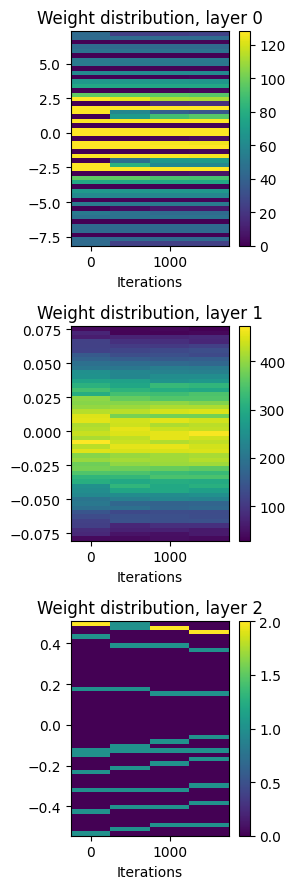

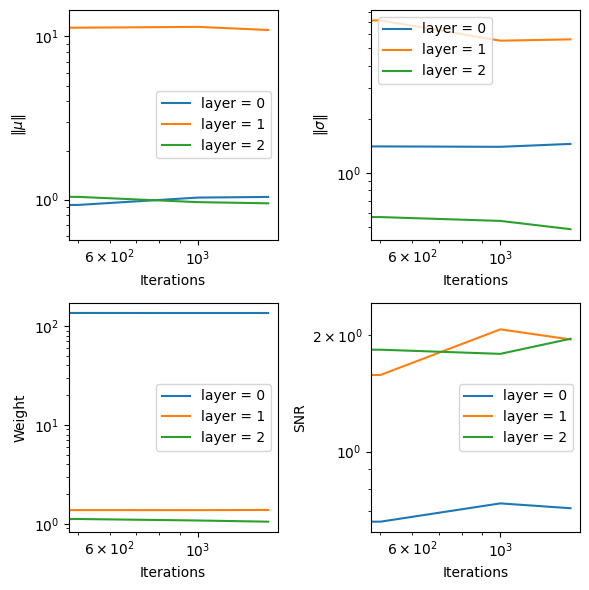

step=Array(0, dtype=int64)
step=Array(500, dtype=int64)
step=Array(1000, dtype=int64)
step=Array(1500, dtype=int64)
IT.shape=(49, 4), BIN.shape=(49, 4)
IT.shape=(49, 4), BIN.shape=(49, 4)
IT.shape=(49, 4), BIN.shape=(49, 4)


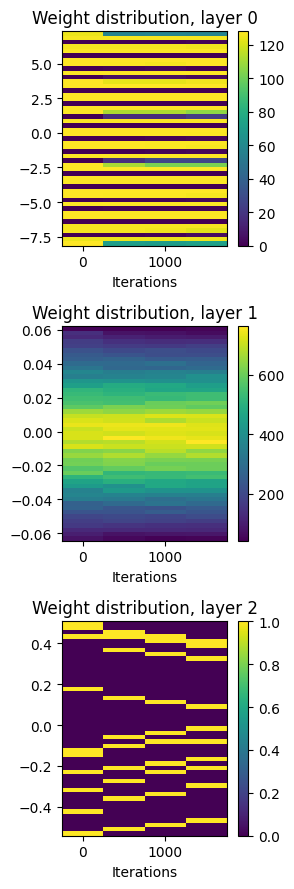

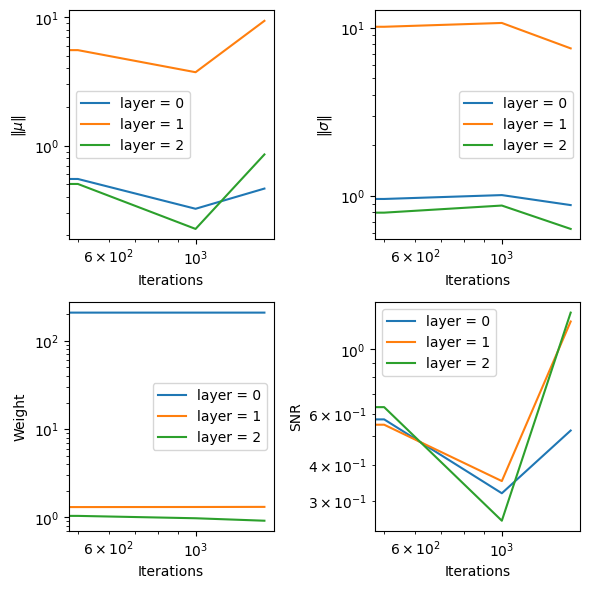

In [101]:
#@title Calculate SNR
for description in descriptions:
    iters_all = jnp.arange(0, len(loss1), snr_every)
    wnorm_all = [] # norm of weights in layer
    gmnorm_all = [] # mean of backpropagated gradient with respect to weights
    gsnorm_all = [] # std of backpropagated gradient with respect to weights
    wdist_all = [] # histogram of weights in each layer, over the steps

    bin_edges = []

    for l in range(len(iters_all)):
        step = iters_all[l]
        with open(f"{description}_params_iter{step}.pkl", 'rb') as f:
            # The protocol version used is detected automatically, so we do not
            # have to specify it.
            params_info = pickle.load(f)

        params = params_info[0]
        grads_all = params_info[1]

        wnorm_now = []
        gmnorm_now = []
        gsnorm_now = []
        wdist_now = []

        for layer in range(len(params)):
            wnorm_l = jnp.linalg.norm(params[layer][0], ord=2)

            if l == 0:
                bin_edges.append(jnp.linspace(jnp.min(params[layer][0]), jnp.max(params[layer][0]), num = 50)) # different bins for each layer, same bins and different histogram for each l


            wdist_l, bin_edges_l = jnp.histogram(params[layer][0], bin_edges[layer])  # bin_edges_l is the same as bins[layer]

            gmnorm_l = jnp.mean(jnp.array(grads_all[layer][0]), axis = 0)
            gmnorm_l = jnp.linalg.norm(gmnorm_l)
            gsnorm_l = jnp.std(jnp.array(grads_all[layer][0]), axis = 0)
            gsnorm_l = jnp.linalg.norm(gsnorm_l)

            wnorm_now.append(wnorm_l)
            gmnorm_now.append(gmnorm_l)
            gsnorm_now.append(gsnorm_l)
            wdist_now.append(wdist_l)

        wnorm_all.append(jnp.array(wnorm_now))
        gmnorm_all.append(jnp.array(gmnorm_now))
        gsnorm_all.append(jnp.array(gsnorm_now))
        wdist_all.append(jnp.array(wdist_now))
        print(f"{step=}")


    wnorm = np.array(wnorm_all)
    gmnorm = np.array(gmnorm_all)
    gsnorm = np.array(gsnorm_all)
    wdist = np.array(wdist_all)
    bin_edges = np.array(bin_edges)

    mdic = {"W": wnorm, "Gm": gmnorm, "Gs": gsnorm, "t": iters_all, "Wdist": wdist, "BinEdges": bin_edges}
    FileName = f'{description}_SNR_analysis.mat'
    savemat(FileName, mdic)

    fig = plt.figure(figsize = (3, 3 * len(params)))

    for layer in range(len(params)):
        ax = fig.add_subplot(len(params), 1, layer + 1)
        ax.set_title(f"Weight distribution, layer {layer}")
        ax.set_xlabel("Iterations")
        IT, BIN = jnp.meshgrid(iters_all, bin_edges[layer][:-1])
        print(f"{IT.shape=}, {BIN.shape=}")
        h = ax.pcolormesh(IT, BIN, wdist[:, layer, :].T, shading = 'nearest')
        plt.colorbar(h)
    plt.tight_layout()
    plt.savefig(f"{description}_weightdist.png")
    plt.show()


    fig = plt.figure(figsize = (6, 6))
    for (ylabel, name, measure, ax_loc) in [("$\|\mu\|$", "mean", gmnorm, 1), ("$\|\sigma\|$", "std", gsnorm, 2), ("Weight", "weight", wnorm, 3), ("SNR", "snr", gmnorm / gsnorm, 4)]:
        ax = fig.add_subplot(2, 2, ax_loc)
        for layer in range(0, len(params)):
            ax.loglog(iters_all, measure[:, layer], label = f"layer = {layer}")

        ax.set_ylabel(ylabel)
        ax.set_xlabel("Iterations")
        ax.legend()
    plt.tight_layout()
    plt.savefig(f"{description}_snr.png")
    plt.show()

[Array(0.35887999, dtype=float64)]
i=0, loss=Array([0.62235117, 0.5155005 , 0.42504076, ..., 0.01040539, 0.00955052,
       0.01302413], dtype=float64)
1.0781856053611089e-06, 0.2556266999935833


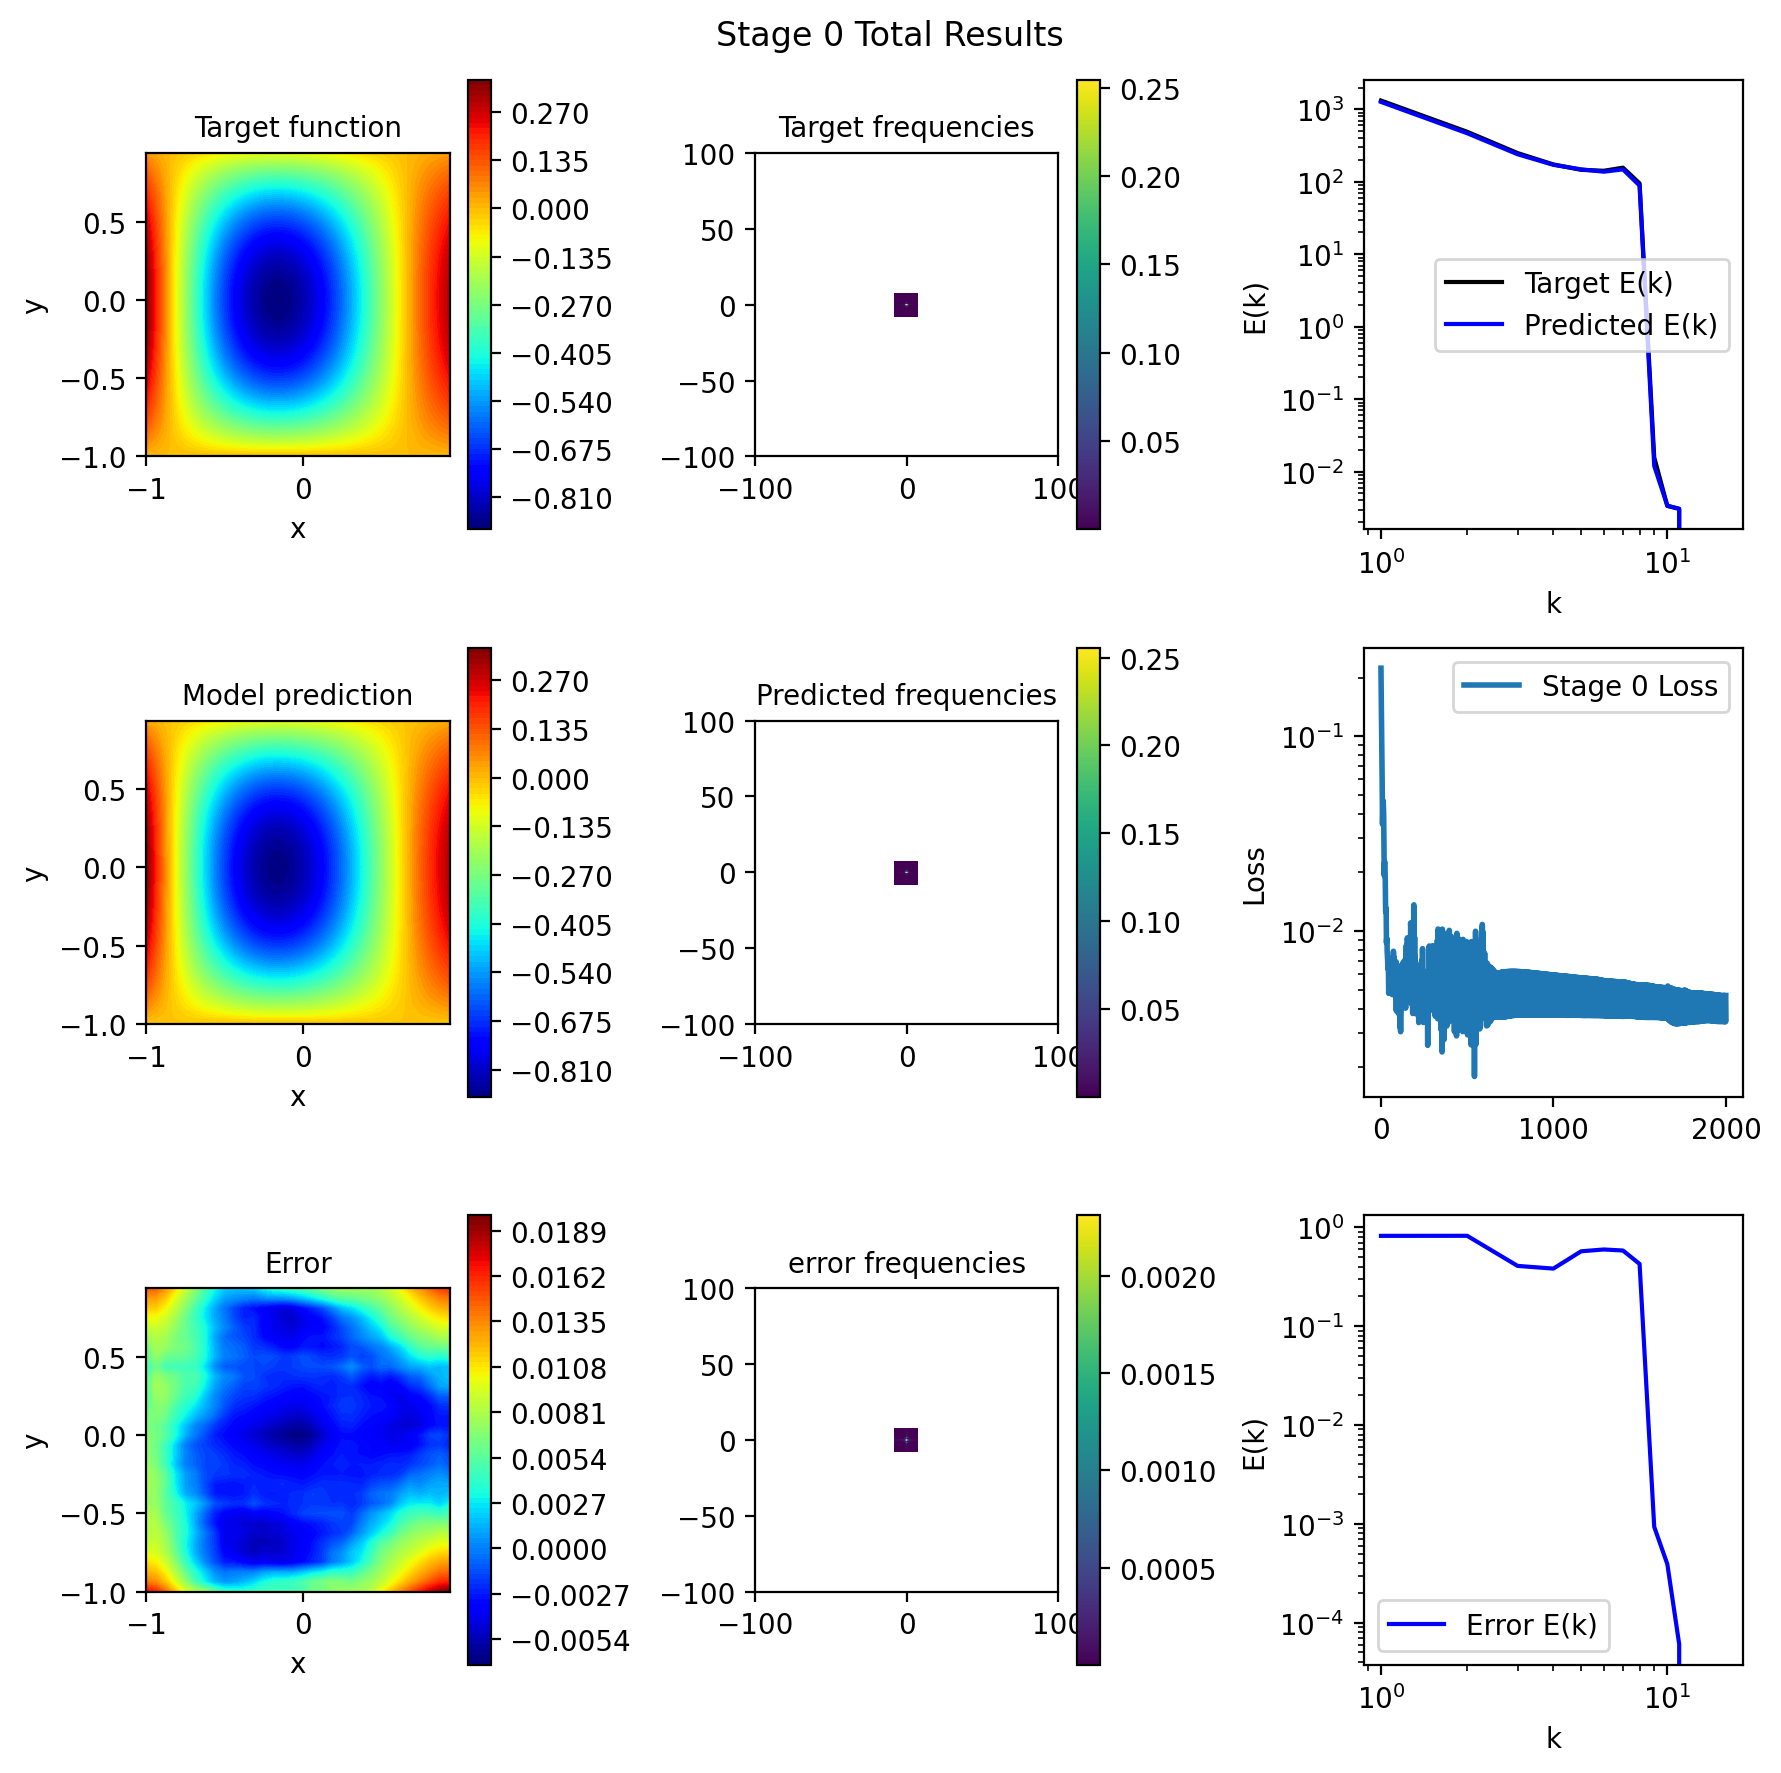

In [48]:
#@title Plot sum
def plot_results(U, U_p, loss = None, stage = "", filename = "reg2d_results.png", title = "Results"):
    U = U
    U_p = U_p
    dpi = 200
    fig = plt.figure(figsize = [9, 9], dpi = dpi)

    u_target = U.reshape(N_y, N_x)
    u_pred = U_p.reshape(N_y, N_x)
    u_min = min(jnp.min(u_target), jnp.min(u_pred))
    u_max = max(jnp.max(u_target), jnp.max(u_pred))
    error = u_target - u_pred
    err_min = jnp.min(error)
    err_max = jnp.max(error)
    axis_fontsize = 10

    # Target
    ax = fig.add_subplot(3, 3, 1)
    ax.set_xlabel('x', fontsize = axis_fontsize)
    ax.set_ylabel('y', fontsize = axis_fontsize)
    ax.set_title('Target function', fontsize = axis_fontsize)
    ax.set_aspect('equal')
    h = ax.contourf(X, Y, u_target, levels = 100, cmap = 'jet', vmin = u_min, vmax = u_max)
    plt.colorbar(h, ax = ax)

    # Plot model prediction
    ax = fig.add_subplot(3, 3, 4)
    ax.set_xlabel('x', fontsize = axis_fontsize)
    ax.set_ylabel('y', fontsize = axis_fontsize)
    ax.set_title(f'Model prediction', fontsize = axis_fontsize)
    h = ax.contourf(X, Y, u_pred, levels = 100, cmap = 'jet', vmin = u_min, vmax = u_max)
    ax.set_aspect('equal')
    plt.colorbar(h, ax = ax)

    # Plot error
    ax = fig.add_subplot(3, 3, 7)
    ax.set_xlabel('x', fontsize = axis_fontsize)
    ax.set_ylabel('y', fontsize = axis_fontsize)
    ax.set_title('Error', fontsize = axis_fontsize)
    h = ax.contourf(X, Y, error, levels = 100, cmap = 'jet', vmin = err_min, vmax = err_max)
    ax.set_aspect('equal')
    plt.colorbar(h, ax = ax)

    # Frequencies of actual solution
    ax = fig.add_subplot(3, 3, 2)
    timestep = jnp.array([N_x, N_y]) / (limit[1] - limit[0])
    freq_x = jnp.fft.fftshift(jnp.fft.fftfreq(n = N_x, d = 1 / timestep[0])) # frequency in multiples of 1/pi cycles/second
    freq_y = jnp.fft.fftshift(jnp.fft.fftfreq(n = N_y, d = 1 / timestep[1]))
    norm = 'forward'
    FS = jnp.fft.fftn(u_target, norm = norm)
    FS_abs = np.abs(np.fft.fftshift(FS))
    h = ax.pcolormesh(freq_x, freq_y, np.abs(np.fft.fftshift(FS)), shading = "auto")
    plt.colorbar(h, ax = ax)

    f_max = 100
    ax.set_xlim(xmin = -1 * f_max, xmax = f_max)
    # ax.set_ylim(ymin = 0, ymax = f_max)
    ax.set_ylim(ymin = -1 * f_max, ymax = f_max)
    ax.set_title('Target frequencies', fontsize = axis_fontsize)
    ax.set_aspect('equal')

    # Frequencies of predicted solution
    ax = fig.add_subplot(3, 3, 5)
    FS = jnp.fft.fftn(u_pred, norm = norm)
    FS_abs = np.abs(np.fft.fftshift(FS))
    ax.set_aspect('equal')
    print(f"{FS_abs.min()}, {FS_abs.max()}")
    h = ax.pcolormesh(freq_x, freq_y, FS_abs, shading = "auto")#, norm = mpl.colors.LogNorm(vmin=FS_abs.min(), vmax=FS_abs.max()))
    plt.colorbar(h, ax = ax)
    ax.set_xlim(xmin = -1 * f_max, xmax = f_max)
    ax.set_ylim(ymin = -1 * f_max, ymax = f_max)
    ax.set_title('Predicted frequencies', fontsize = axis_fontsize)
    ax.set_aspect('equal')

    # Frequencies of error
    ax = fig.add_subplot(3, 3, 8)
    FS = jnp.fft.fftn(error, norm = norm)
    FS_abs = np.abs(np.fft.fftshift(FS))
    argmax = np.unravel_index(FS_abs.argmax(), FS_abs.shape)

    h = ax.pcolormesh(freq_x, freq_y, np.abs(np.fft.fftshift(FS)), shading = "auto")
    plt.colorbar(h, ax = ax)
    ax.set_xlim(xmin = -1 * f_max, xmax = f_max)
    ax.set_ylim(ymin = -1 * f_max, ymax = f_max)
    ax.set_title('error frequencies', fontsize = axis_fontsize)
    ax.set_aspect('equal')

            # Energy spectrum of actual solution
    ax = fig.add_subplot(3, 3, 3)
    KX, KY = jnp.meshgrid(freq_x, freq_y)
    k2 = KX ** 2 + KY ** 2 # wave number squared
    psihat = jnp.fft.fftshift(jnp.fft.fft2(U))
    tke = jnp.real(.5 * k2 * psihat * jnp.conj(psihat))
    kmod = jnp.sqrt(k2)
    k = jnp.arange(1, psihat.shape[0] // 2 + 1, 1, dtype=jnp.float64) # nyquist limit for this grid
    E = jnp.zeros_like(k)
    res = 200 # resolution
    dk = (jnp.max(k) - jnp.min(k)) / res

        #  binning energies with wavenumber modulus in threshold
    for i in range(len(k)):
        E = E.at[i].add(jnp.sum(tke[(kmod < k[i] + dk) & (kmod >= k[i] - dk)]))
    sum_E = jnp.sum(E)
        # angle averaged Turbulent Kinetic Energy spectrum
    ax.loglog(k, E, '-k', label = "Target E(k)")
    ax.set_xlabel("k")
    ax.set_ylabel("E(k)")
    ax.legend()

    # Energy spectrum of predicted solution
    psihat = jnp.fft.fftshift(jnp.fft.fft2(U_p))
    tke = jnp.real(.5 * k2 * psihat * jnp.conj(psihat))
    kmod = jnp.sqrt(k2)
    k = jnp.arange(1, psihat.shape[0] // 2 + 1, 1, dtype=jnp.float64) # nyquist limit for this grid
    E = jnp.zeros_like(k)
    res = 200 # resolution
    dk = (jnp.max(k) - jnp.min(k)) / res

        #  binning energies with wavenumber modulus in threshold
    for i in range(len(k)):
        E = E.at[i].add(jnp.sum(tke[(kmod < k[i] + dk) & (kmod >= k[i] - dk)]))
    sum_E = jnp.sum(E)
        # angle averaged Turbulent Kinetic Energy spectrum
    ax.loglog(k, E, '-b', label = "Predicted E(k)")
    ax.set_xlabel("k")
    ax.set_ylabel("E(k)")
    ax.legend()

    # Energy spectrum of error
    ax = fig.add_subplot(3, 3, 9)
    psihat = jnp.fft.fftshift(jnp.fft.fft2(U - U_p))
    tke = jnp.real(.5 * k2 * psihat * jnp.conj(psihat))
    kmod = jnp.sqrt(k2)
    k = jnp.arange(1, psihat.shape[0] // 2 + 1, 1, dtype=jnp.float64) # nyquist limit for this grid
    E = jnp.zeros_like(k)
    res = 200 # resolution
    dk = (jnp.max(k) - jnp.min(k)) / res

        #  binning energies with wavenumber modulus in threshold
    for i in range(len(k)):
        E = E.at[i].add(jnp.sum(tke[(kmod < k[i] + dk) & (kmod >= k[i] - dk)]))
    sum_E = jnp.sum(E)
        # angle averaged Turbulent Kinetic Energy spectrum
    ax.loglog(k, E, '-b', label = "Error E(k)")
    ax.set_xlabel("k")
    ax.set_ylabel("E(k)")
    ax.legend()


    # Loss
    if loss is not None:
        ax = fig.add_subplot(3, 3, 6)
        ax.set_ylabel("Loss", fontsize = axis_fontsize, rotation = 90)
        ax.set_yscale('log')
        n = 0
        # Plot loss, labeled by optimization method
        for i, loss_i in enumerate(loss):
            n_iter = len(loss_i)
            ax.plot(jnp.arange(n, n + n_iter), loss_i, '-', linewidth = 2, label = f"Stage {i} Loss")
            n += n_iter
        ax.legend()

    # plt.tight_layout()
    fig.suptitle(title)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close('all')

# U_p_stages.append(U_p)
# eps_stages.append(eps * (-1) ** stage)
print(eps_stages)
# sum_start = eps_stages[0] * jnp.array(U_p_stages[0])
# plot_results(U_0, sum_start, loss = None, stage = stage, filename = f'{description}', title = f"Stage {stage} intermediate")

# for i in range(1, len(U_p_stages)):
#     # plot_results(eps_stages[i] * jnp.array(U_p_stages[i]), eps_stages[i] * jnp.array(U_p_stages[i]), loss = None, stage = stage, filename = f'{description}', title = f"Stage {stage} intermediate")
#     sum_start += eps_stages[i] * 1 / eps_stages[0] * eps_stages[1] * jnp.array(U_p_stages[i])
#     plot_results(U_0, sum_start, loss = None, stage = stage, filename = f'{description}', title = f"Stage {stage} intermediate")

loss_stages_eps = []
for i, loss in enumerate(loss_stages):
    print(f"{i=}, {loss=}")
    loss_stages_eps.append(eps_stages[i] * jnp.array(loss))

U_p_total = jnp.sum(jnp.array(U_p_stages), axis = 0)
plot_results(U_0, U_p_total, loss = loss_stages_eps, stage = stage, filename = f'{description}_total_results.png', title = f"Stage {stage} Total Results")


FileNotFoundError: [Errno 2] No such file or directory: 'reg2d_test2_p10_iters150000_stage0_fourinitTrue_act1_10000_results copy.mat'

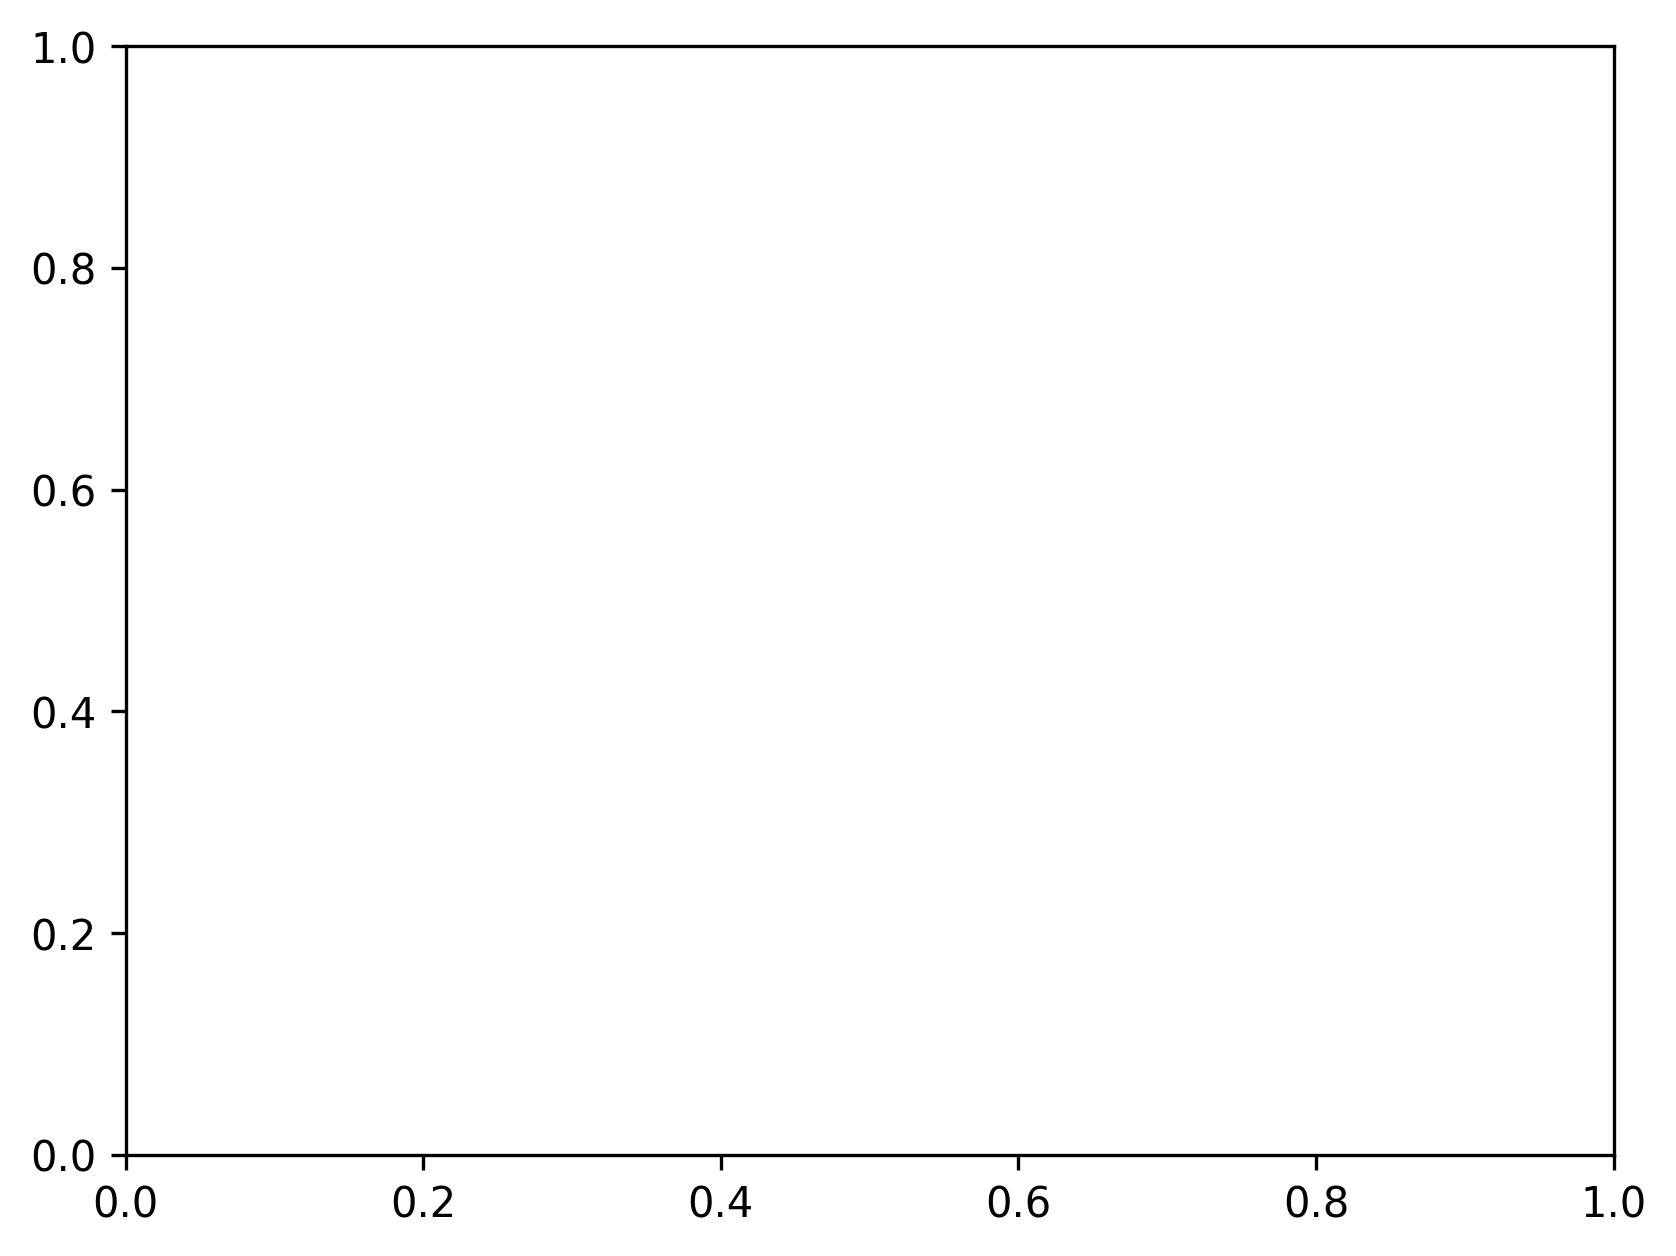

In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
#import jax.numpy as np
import numpy as np

dpi = 300
fig = plt.figure(dpi = dpi)
ax = fig.add_subplot(1, 1, 1)
stages = []
for i in range(4):
    stages.append(scipy.io.loadmat(f"reg2d_test2_p10_iters150000_stage{i}_fourinitTrue_act1_10000_results copy.mat"))
stages_long = scipy.io.loadmat("reg2d_test2_p10_iters600000_stage0_fourinitTrue_act1_10000_results copy.mat")
X = stages_long['X']
Y = stages_long['Y']
U = stages_long['U']
N_x, N_y = X.shape
lb = [-1, -1]
ub = [1, 1]
limit = np.array([lb, ub])
print(f"{N_x=}, {N_y=}")

# Frequencies of actual solution
timestep = np.array([N_x, N_y]) / (limit[1] - limit[0])
freq_x = np.fft.fftshift(np.fft.fftfreq(n = N_x, d = 1 / timestep[0])) # frequency in multiples of 1/pi cycles/second
freq_y = np.fft.fftshift(np.fft.fftfreq(n = N_y, d = 1 / timestep[1]))
norm = 'forward'
# Energy spectrum of actual solution
KX, KY = np.meshgrid(freq_x, freq_y)
k2 = KX ** 2 + KY ** 2 # wave number squared

# for target, label, color in [(U, "Target E(k)", "k"), (stages[0]['U_p'], "Stage 0, 150000 iterations", "k"), (stages[0]['U_p'] + stages[1]['U_p'], "Stage 1, 150000 iterations", "b"), (stages[0]['U_p'] + stages[1]['U_p'] + stages[2]['U_p'], "Stage 2, 150000 iterations", "g"), (stages_long['U_p'], "Stage 0, 600000 iterations", "r")]:
for target, label, color in [(U, "Target E(k)", "k"), (stages[0]['U_p'] + stages[1]['U_p'] + stages[2]['U_p'] + stages[3]['U_p'], "Stage 3, 150000 iterations", "g"), (stages_long['U_p'], "Stage 0, 600000 iterations", "r")]:
    psihat = np.fft.fftshift(np.fft.fft2(target))
    tke = np.real(.5 * k2 * psihat * np.conj(psihat))
    kmod = np.sqrt(k2)
    k = np.arange(1, psihat.shape[0] // 2 + 1, 1, dtype=np.float64) # nyquist limit for this grid
    E = np.zeros_like(k)
    res = 200 # resolution
    dk = (np.max(k) - np.min(k)) / res

    #  binning energies with wavenumber modulus in threshold
    for i in range(len(k)):
        E[i] += np.sum(tke[(kmod < k[i] + dk) & (kmod >= k[i] - dk)])
    sum_E = np.sum(E)
        # angle averaged Turbulent Kinetic Energy spectrum
    if label == 'Target E(k)':
        ax.loglog(k, E, f'-{color}', label = label, alpha = 0.2, linewidth = 5)
    else:
        ax.loglog(k, E, f'-{color}', label = label)
ax.set_xlabel("Wavenumber k")
ax.set_ylabel("E(k)")
ax.legend()
ax.set_title("2D Turbulence Energy Spectrum")
plt.savefig("reg2d_test2_p10_iters150000_stage0_fourinitTrue_act1_10000_energy_spectrum.png")
plt.show()

fig = plt.figure()
axis_fontsize = 12
stage0loss = stages[0]['loss'][0]
stage1loss = stages[1]['loss'][0]
stage2loss = stages[2]['loss'][0]
stage3loss = stages[3]['loss'][0]
stage0loss_long = stages_long['loss'][0]

ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel("Loss", fontsize = axis_fontsize, rotation = 90)
ax.set_xlabel("Iterations")
ax.set_title("Loss Convergence")
ax.set_yscale('log')


ax.plot(np.arange(0, stage0loss_long.shape[0]), stage0loss_long, '-r', linewidth = 1, label = f"Stage 0, 600000 iterations")
ax.plot(np.arange(0, stage0loss.shape[0]), stage0loss, '--k', linewidth = 1, label = f"Stage 0, 150000 iterations")
ax.plot(np.arange(stage0loss.shape[0], stage0loss.shape[0] + stage1loss.shape[0]), stage1loss, '-b', linewidth = 1, label = f"Stage 1, 150000 iterations")
ax.plot(np.arange(stage0loss.shape[0] + stage1loss.shape[0], stage0loss.shape[0] + stage1loss.shape[0] + stage2loss.shape[0]), stage2loss, '-g', linewidth = 1, label = f"Stage 2, 150000 iterations")
ax.plot(np.arange(stage0loss.shape[0] + stage1loss.shape[0] + stage2loss.shape[0], stage0loss.shape[0] + stage1loss.shape[0] + stage2loss.shape[0] + stage3loss.shape[0]), stage3loss, color = 'orange', linewidth = 1, label = f"Stage 3, 150000 iterations")

ax.legend()
plt.savefig("reg2d_test2_p10_iters150000_stage0_fourinitTrue_act1_10000_loss.png")
plt.show()

In [ ]:
seed = 1701
key = jax.random.key(seed)
key1, key2, key3 = jax.random.split(key, num = 3)
# H.shape=(900, 120), layer[0].shape=(120, 30), layer[1].shape=(30,)


# shape of layer[0] is [10 x 10]
# shape of H is []
H = jax.random.normal(key = key1, shape = (900, 1200))
layer = []
layer.append(jax.random.normal(key = key2, shape = (1200, 30)))
layer.append(jax.random.normal(key = key3, shape = (30,)))

# result = jnp.tanh(jnp.dot(H, layer[0]) + layer[1])

max_width = 123
result0 = jnp.dot(H[:, :max_width], layer[0][:max_width])
print(f"{result0.shape=}")
for i in range(1, int(jnp.ceil(layer[0].shape[0] / max_width))):
    # print(H[i * max_width : (i + 1) * max_width].shape)
    # print(result0)
    # print(jnp.dot(H[i * max_width : (i + 1) * max_width], layer[0]))
    result0 = result0 + jnp.dot(H[:, i * max_width : (i + 1) * max_width], layer[0][i * max_width : (i + 1) * max_width])
# print(layer[0])
print(f"{result0.shape=}")
result = jnp.dot(H, layer[0])
print(f"{jnp.all(jnp.abs(result0 - result) <= 0.000000000001)=}")

In [ ]:
import numpy as np
L = 2 * np.pi
N = 512
kx = np.fft.fftfreq(N, d = L / (N * 2 * np.pi))
print(f"{kx=}")
kx_bad = np.fft.fftfreq(N, d = 2 / (N))
print(f"{kx_bad=}")

In [ ]:
X, Y = jnp.meshgrid(jnp.arange(10, 12), jnp.arange(10, 13))
print(X)
print(jnp.array_split(X, 2))